In [2]:
# ============================================================
# PROJETO A1 — Nova Tratativa para A1_ML_DL_features.csv (sem v)
# - Separa linhas com wr==0 ou wm==0
# - Salva CSVs (onlyzeros / nozeros) + manifesto
# - Treina MVP (RF multi-alvo) no nozeros e salva artefatos
# ============================================================
import os, json, hashlib
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# ----------------- PATHS -----------------
BASE = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
INP  = os.path.join(BASE, "data", "curated", "A1_ML_DL_features.csv")

OUT_BASE = os.path.join(BASE, "outputs", "nova_tratativa", "base_dados")
OUT_MOD  = os.path.join(BASE, "outputs", "nova_tratativa", "models")
os.makedirs(OUT_BASE, exist_ok=True)
os.makedirs(OUT_MOD,  exist_ok=True)

TAG = datetime.now().strftime("%Y%m%d_%H%M")

YCOLS = ["wr_kg_m2_h","wm_kg_m2_h"]

# ----------------- UTILS -----------------
def read_multiheader_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Arquivo não encontrado: {path}")
    dfr = pd.read_csv(path, header=[0,1], engine="python")
    df  = dfr.copy()
    df.columns = [c for (c,_) in dfr.columns]   # usa linha 1 (nomes)
    return df

def find_timecol(df):
    cand = [c for c in df.columns if str(c).lower().startswith(("time", "data", "date", "hora", "timestamp", "datetime", "ts"))]
    if not cand:
        return None, None
    s = pd.to_datetime(df[cand[0]], errors="coerce")
    if s.notna().mean() < 0.5:
        return None, None
    return s, cand[0]

def rmse_np(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def sha256_of(path, chunk=1<<20):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for b in iter(lambda: f.read(chunk), b""):
            h.update(b)
    return h.hexdigest()

# ----------------- 1) CARREGAR & LIMPAR -----------------
df = read_multiheader_csv(INP)
ts_col, ts_name = find_timecol(df)
if ts_col is not None:
    order = ts_col.argsort(kind="mergesort")
    df = df.iloc[order].reset_index(drop=True)
    ts_col = ts_col.iloc[order].reset_index(drop=True)

# confirma alvos
if not all(c in df.columns for c in YCOLS):
    raise RuntimeError(f"Alvos ausentes. Esperado: {YCOLS}. Colunas disponíveis: {df.columns[:10].tolist()} ...")

# numeric only + mantém alvos
for c in YCOLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ----------------- 2) SEPARAR ZEROS vs NÃO-ZEROS -----------------
mask_zero = (df[YCOLS[0]]==0) | (df[YCOLS[1]]==0)
df_onlyzeros = df.loc[mask_zero].copy()
df_nozeros   = df.loc[~mask_zero].copy()

# Paths de saída
P_ONLY = os.path.join(OUT_BASE, f"A1_ML_DL_features_onlyzeros_{TAG}.csv")
P_NOZ  = os.path.join(OUT_BASE, f"A1_ML_DL_features_nozeros_{TAG}.csv")
df_onlyzeros.to_csv(P_ONLY, index=False)
df_nozeros.to_csv(P_NOZ, index=False)

# Manifesto da base
manifest = {
    "generated_at": datetime.now().isoformat(),
    "input_file": INP,
    "time_column": ts_name,
    "rows_total": int(len(df)),
    "rows_onlyzeros": int(len(df_onlyzeros)),
    "rows_nozeros": int(len(df_nozeros)),
    "ycols": YCOLS,
    "time_start_total": str(ts_col.min()) if ts_col is not None else None,
    "time_end_total":   str(ts_col.max()) if ts_col is not None else None,
    "files": {
        "onlyzeros_csv": {"path": P_ONLY, "sha256": sha256_of(P_ONLY)},
        "nozeros_csv":   {"path": P_NOZ,  "sha256": sha256_of(P_NOZ)},
    }
}
with open(os.path.join(OUT_BASE, f"manifest_base_{TAG}.json"), "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2, ensure_ascii=False)

print("== BASE SALVA ==")
print(f"onlyzeros: {P_ONLY}")
print(f"nozeros:   {P_NOZ}")
print(f"manifest:  {os.path.join(OUT_BASE, f'manifest_base_{TAG}.json')}")

# ----------------- 3) TREINO MVP NO NO-ZEROS -----------------
# separa X/Y
df_work = df_nozeros.copy()

# Remove linhas com NaN nos alvos antes do split
df_work = df_work.dropna(subset=YCOLS)

# (re)descobre timestamp para nozeros
if ts_name and ts_name in df_work.columns:
    ts_work = pd.to_datetime(df_work[ts_name], errors="coerce")
else:
    ts_work = pd.Series(pd.NaT, index=df_work.index)

X_all = df_work.select_dtypes(include=[np.number]).drop(columns=YCOLS, errors="ignore")
y_all = df_work[YCOLS].apply(pd.to_numeric, errors="coerce").values

n = len(df_work)
idx = np.arange(n)
# split temporal conforme ordem atual (já ordenada por ts se disponível)
train_end = int(0.7*n); val_end = int(0.8*n)
idx_tr, idx_va, idx_te = idx[:train_end], idx[train_end:val_end], idx[val_end:]

def slice_(X, y, ix):
    return X.iloc[ix], y[ix]

X_tr, y_tr = slice_(X_all, y_all, idx_tr)
X_va, y_va = slice_(X_all, y_all, idx_va)
X_te, y_te = slice_(X_all, y_all, idx_te)

# pipeline
imp = SimpleImputer(strategy="median")
sc  = StandardScaler()
X_tr_p = sc.fit_transform(imp.fit_transform(X_tr))
X_va_p = sc.transform(imp.transform(X_va))
X_te_p = sc.transform(imp.transform(X_te))

# modelo
model = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=400, random_state=42, n_jobs=-1
))
model.fit(X_tr_p, y_tr)

# métricas seguras (NumPy)
def eval_split(y_true, y_pred):
    out = {}
    for j, col in enumerate(YCOLS):
        yt, yp = y_true[:,j], y_pred[:,j]
        out[col] = {
            "R2":  float(r2_score(yt, yp)),
            "RMSE": rmse_np(yt, yp),
            "MAE":  float(np.mean(np.abs(yt-yp))),
        }
    return out

pred_tr = model.predict(X_tr_p)
pred_va = model.predict(X_va_p)
pred_te = model.predict(X_te_p)

m_tr = eval_split(y_tr, pred_tr)
m_va = eval_split(y_va, pred_va)
m_te = eval_split(y_te, pred_te)

# tabela resumida
def sumrow(split, m):
    return {
        "split": split,
        "R2_wr":  m["wr_kg_m2_h"]["R2"],
        "RMSE_wr":m["wr_kg_m2_h"]["RMSE"],
        "MAE_wr": m["wr_kg_m2_h"]["MAE"],
        "R2_wm":  m["wm_kg_m2_h"]["R2"],
        "RMSE_wm":m["wm_kg_m2_h"]["RMSE"],
        "MAE_wm": m["wm_kg_m2_h"]["MAE"],
        "linhas": int({"treino":len(idx_tr), "validacao":len(idx_va), "teste":len(idx_te)}[split]),
        "inicio": str(ts_work.iloc[idx_tr[0]] if split=="treino"   else ts_work.iloc[idx_va[0]] if split=="validacao" else ts_work.iloc[idx_te[0]] if len(idx_te) else pd.NaT),
        "fim":    str(ts_work.iloc[idx_tr[-1]]if split=="treino"   else ts_work.iloc[idx_va[-1]] if split=="validacao" else ts_work.iloc[idx_te[-1]] if len(idx_te) else pd.NaT),
    }

tbl = pd.DataFrame([
    sumrow("treino",    m_tr),
    sumrow("validacao", m_va),
    sumrow("teste",     m_te),
])

# ----------------- 4) SALVAR ARTEFATOS DO MODELO -----------------
MPATH   = os.path.join(OUT_MOD, f"model_mvp_nozeros_{TAG}.joblib")
MPATH_M = os.path.join(OUT_MOD, f"metrics_nozeros_{TAG}.csv")
MCARD   = os.path.join(OUT_MOD, f"model_card_nozeros_{TAG}.md")

import joblib
joblib.dump({
    "model": model,
    "imputer": imp,
    "scaler": sc,
    "feature_names": X_all.columns.tolist(),
    "y_names": YCOLS,
    "splits": {"train": idx_tr.tolist(), "val": idx_va.tolist(), "test": idx_te.tolist()},
    "src_data_nozeros_csv": P_NOZ,
}, MPATH)

tbl.to_csv(MPATH_M, index=False)

with open(MCARD, "w", encoding="utf-8") as f:
    f.write(f"""# A1 — MVP (features sem zeros nos alvos)\n
**Data**: {datetime.now().isoformat()}\n
**Entrada**: `{P_NOZ}`\n
**Modelo**: RandomForestRegressor (MultiOutput), n_estimators=400\n
**Split temporal**: 70/10/20 (ordem do CSV{' ordenado por '+ts_name if ts_name else ''})\n
## Métricas
{tbl.to_string(index=False)}
""")

print("\n== MODELO SALVO ==")
print("joblib: ", MPATH)
print("metrics:", MPATH_M)
print("card:   ", MCARD)

print("\n=== RESUMO ===")
print(tbl)


== BASE SALVA ==
onlyzeros: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\base_dados\A1_ML_DL_features_onlyzeros_20250818_1157.csv
nozeros:   C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\base_dados\A1_ML_DL_features_nozeros_20250818_1157.csv
manifest:  C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\base_dados\manifest_base_20250818_1157.json

== MODELO SALVO ==
joblib:  C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\models\model_mvp_nozeros_20250818_1157.joblib
metrics: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\models\metrics_nozeros_20250818_1157.csv
card:    C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\models\model_card_nozeros_20250818_1157.md

=== RESUMO ===
       split     R2_wr       RMSE_wr       MAE_wr     R2_wm       RMSE_wm  \
0     treino  

In [4]:
# ============================================================
# Nova Tratativa v2 — separa ZERO e NaN nos alvos e refaz o treino
# ============================================================
import os, json, hashlib
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import joblib

# ----------------- PATHS -----------------
BASE = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
INP  = os.path.join(BASE, "data", "curated", "A1_ML_DL_features.csv")

OUT_BASE = os.path.join(BASE, "outputs", "nova_tratativa", "base_dados")
OUT_MOD  = os.path.join(BASE, "outputs", "nova_tratativa", "models")
os.makedirs(OUT_BASE, exist_ok=True)
os.makedirs(OUT_MOD,  exist_ok=True)

TAG = datetime.now().strftime("%Y%m%d_%H%M")
YCOLS = ["wr_kg_m2_h","wm_kg_m2_h"]

def read_multiheader_csv(path):
    dfr = pd.read_csv(path, header=[0,1], engine="python")
    df  = dfr.copy()
    df.columns = [c for (c,_) in dfr.columns]   # usa 1ª linha (nomes)
    return df

def find_timecol(df):
    cand = [c for c in df.columns if str(c).lower().startswith(("time","data","date","hora","timestamp","datetime","ts"))]
    if not cand: return None, None
    s = pd.to_datetime(df[cand[0]], errors="coerce")
    return (s if s.notna().mean()>=0.5 else None), (cand[0] if s.notna().mean()>=0.5 else None)

def rmse_np(y_true, y_pred): return float(np.sqrt(np.mean((y_true - y_pred)**2)))
def sha256_of(path, chunk=1<<20):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for b in iter(lambda: f.read(chunk), b""):
            h.update(b)
    return h.hexdigest()

# 1) Ler e ordenar por tempo (se houver)
df = read_multiheader_csv(INP)
ts_col, ts_name = find_timecol(df)
if ts_col is not None:
    order = ts_col.argsort(kind="mergesort")
    df = df.iloc[order].reset_index(drop=True)
    ts_col = ts_col.iloc[order].reset_index(drop=True)

# Garantir numérico nos alvos
for c in YCOLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 2) Separar subconjuntos
mask_zero = (df[YCOLS[0]]==0) | (df[YCOLS[1]]==0)
mask_nan  = df[YCOLS].isna().any(axis=1)
mask_bad  = mask_zero | mask_nan
df_onlyzeros      = df.loc[ mask_zero].copy()
df_onlynans       = df.loc[ mask_nan & ~mask_zero].copy()
df_nozeros_nonan  = df.loc[~mask_bad].copy()

# 3) Salvar bases
P_ONLYZ = os.path.join(OUT_BASE, f"A1_ML_DL_features_onlyzeros_{TAG}.csv")
P_ONLYN = os.path.join(OUT_BASE, f"A1_ML_DL_features_onlynans_{TAG}.csv")
P_CLEAN = os.path.join(OUT_BASE, f"A1_ML_DL_features_nozeros_nonan_{TAG}.csv")
df_onlyzeros.to_csv(P_ONLYZ, index=False)
df_onlynans.to_csv(P_ONLYN, index=False)
df_nozeros_nonan.to_csv(P_CLEAN, index=False)

manifest = {
  "generated_at": datetime.now().isoformat(),
  "input_file": INP,
  "time_column": ts_name,
  "ycols": YCOLS,
  "rows_total": int(len(df)),
  "rows_onlyzeros": int(len(df_onlyzeros)),
  "rows_onlynans": int(len(df_onlynans)),
  "rows_clean": int(len(df_nozeros_nonan)),
  "time_start_total": str(ts_col.min()) if ts_col is not None else None,
  "time_end_total":   str(ts_col.max()) if ts_col is not None else None,
  "files": {
    "onlyzeros_csv": {"path": P_ONLYZ, "sha256": sha256_of(P_ONLYZ)},
    "onlynans_csv":  {"path": P_ONLYN, "sha256": sha256_of(P_ONLYN)},
    "clean_csv":     {"path": P_CLEAN, "sha256": sha256_of(P_CLEAN)},
  }
}
with open(os.path.join(OUT_BASE, f"manifest_base_{TAG}.json"), "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2, ensure_ascii=False)

print("== BASES SALVAS ==")
print(f"onlyzeros: {P_ONLYZ}")
print(f"onlynans:  {P_ONLYN}")
print(f"clean:     {P_CLEAN}")

# 4) MVP no conjunto LIMPO (sem zero/NaN nos alvos)
dfw = df_nozeros_nonan.copy()
ts_work = pd.to_datetime(dfw[ts_name], errors="coerce") if ts_name in dfw.columns else pd.Series(pd.NaT, index=dfw.index)

X_all = dfw.select_dtypes(include=[np.number]).drop(columns=YCOLS, errors="ignore")
y_all = dfw[YCOLS].to_numpy(dtype=float)

# splits temporais 70/10/20
n = len(dfw)
idx = np.arange(n)
train_end = int(0.7*n); val_end = int(0.8*n)
idx_tr, idx_va, idx_te = idx[:train_end], idx[train_end:val_end], idx[val_end:]

def slice_(X, y, ix):
    return X.iloc[ix], y[ix]
X_tr, y_tr = slice_(X_all, y_all, idx_tr)
X_va, y_va = slice_(X_all, y_all, idx_va)
X_te, y_te = slice_(X_all, y_all, idx_te)

# pipeline
imp = SimpleImputer(strategy="median")
sc  = StandardScaler()
X_tr_p = sc.fit_transform(imp.fit_transform(X_tr))
X_va_p = sc.transform(imp.transform(X_va))
X_te_p = sc.transform(imp.transform(X_te))

# modelo
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))
model.fit(X_tr_p, y_tr)

def eval_split(y_true, y_pred):
    out={}
    for j, col in enumerate(YCOLS):
        yt, yp = y_true[:,j], y_pred[:,j]
        out[col] = {"R2": float(r2_score(yt, yp)),
                    "RMSE": rmse_np(yt, yp),
                    "MAE": float(np.mean(np.abs(yt-yp)))}
    return out

pred_tr = model.predict(X_tr_p)
pred_va = model.predict(X_va_p)
pred_te = model.predict(X_te_p)

m_tr = eval_split(y_tr, pred_tr)
m_va = eval_split(y_va, pred_va)
m_te = eval_split(y_te, pred_te)

def sumrow(split, m):
    return {
        "split": split,
        "linhas": int(len(idx_tr) if split=="treino" else len(idx_va) if split=="validacao" else len(idx_te)),
        "inicio": str(ts_work.iloc[idx_tr[0]] if split=="treino" else ts_work.iloc[idx_va[0]] if split=="validacao" else ts_work.iloc[idx_te[0]] if len(idx_te) else pd.NaT),
        "fim":    str(ts_work.iloc[idx_tr[-1]] if split=="treino" else ts_work.iloc[idx_va[-1]] if split=="validacao" else ts_work.iloc[idx_te[-1]] if len(idx_te) else pd.NaT),
        "R2_wr":  m["wr_kg_m2_h"]["R2"],  "RMSE_wr": m["wr_kg_m2_h"]["RMSE"], "MAE_wr": m["wr_kg_m2_h"]["MAE"],
        "R2_wm":  m["wm_kg_m2_h"]["R2"],  "RMSE_wm": m["wm_kg_m2_h"]["RMSE"], "MAE_wm": m["wm_kg_m2_h"]["MAE"],
    }
tbl = pd.DataFrame([sumrow("treino", m_tr), sumrow("validacao", m_va), sumrow("teste", m_te)])

# 5) Salvar artefatos
MPATH   = os.path.join(OUT_MOD, f"model_mvp_nozeros_nonan_{TAG}.joblib")
MPATH_M = os.path.join(OUT_MOD, f"metrics_nozeros_nonan_{TAG}.csv")
MCARD   = os.path.join(OUT_MOD, f"model_card_nozeros_nonan_{TAG}.md")

joblib.dump({
    "model": model, "imputer": imp, "scaler": sc,
    "feature_names": X_all.columns.tolist(),
    "y_names": YCOLS,
    "splits": {"train": idx_tr.tolist(), "val": idx_va.tolist(), "test": idx_te.tolist()},
    "src_data_clean_csv": P_CLEAN,
    "notes": "Treinado sem zeros e sem NaN nos alvos."
}, MPATH)

tbl.to_csv(MPATH_M, index=False)
with open(MCARD, "w", encoding="utf-8") as f:
    f.write(f"""# A1 — MVP (features.csv sem zeros/NaN nos alvos)\n
**Data**: {datetime.now().isoformat()}\n
**Entrada (limpa)**: `{P_CLEAN}`\n
**Excluídos**:\n- zeros: `{P_ONLYZ}`\n- NaN: `{P_ONLYN}`\n
**Modelo**: RandomForestRegressor (MultiOutput), n_estimators=400\n
**Split temporal**: 70/10/20 (ordem do CSV{' ordenado por '+ts_name if ts_name else ''})\n
## Métricas\n{tbl.to_string(index=False)}
""")

print("\n== MODELO SALVO ==")
print("joblib: ", MPATH)
print("metrics:", MPATH_M)
print("card:   ", MCARD)
print("\n=== RESUMO ===")
print(tbl)


== BASES SALVAS ==
onlyzeros: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\base_dados\A1_ML_DL_features_onlyzeros_20250818_1159.csv
onlynans:  C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\base_dados\A1_ML_DL_features_onlynans_20250818_1159.csv
clean:     C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\base_dados\A1_ML_DL_features_nozeros_nonan_20250818_1159.csv

== MODELO SALVO ==
joblib:  C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\models\model_mvp_nozeros_nonan_20250818_1159.joblib
metrics: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\models\metrics_nozeros_nonan_20250818_1159.csv
card:    C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\models\model_card_nozeros_nonan_20250818_1159.md

=== RESUMO ===
       split  linhas               inicio            

In [5]:
# ============================================================
# Split aleatório 80/20 e treino (RF) no nozeros_nonan  → *_rand80
# ============================================================
import os, glob, json
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import joblib

# ---------- PATHS ----------
BASE      = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
IN_DIR    = os.path.join(BASE, "outputs", "nova_tratativa", "base_dados")
OUT_DIR   = os.path.join(BASE, "outputs", "nova_tratativa", "models")
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- ENTRADA: pega o ÚLTIMO nozeros_nonan_*.csv ----------
cands = glob.glob(os.path.join(IN_DIR, "A1_ML_DL_features_nozeros_nonan_*.csv"))
if not cands:
    raise FileNotFoundError("Não encontrei A1_ML_DL_features_nozeros_nonan_*.csv em " + IN_DIR)
SRC_CLEAN = max(cands, key=os.path.getmtime)  # mais recente
print("[input]", SRC_CLEAN)

# ---------- COLUNAS/ALVOS ----------
YCOLS = ["wr_kg_m2_h","wm_kg_m2_h"]
SEED  = 42  # reprodutibilidade

# ---------- LOAD (header simples; foi salvo já 'flattened') ----------
df = pd.read_csv(SRC_CLEAN)
# tenta inferir a primeir a coluna temporal (apenas informativa)
def find_timecol(d):
    for c in d.columns:
        if str(c).lower().startswith(("time","data","date","hora","timestamp","datetime","ts")):
            s = pd.to_datetime(d[c], errors="coerce")
            if s.notna().mean() >= 0.5:
                return c, s
    return None, pd.Series(pd.NaT, index=d.index)
ts_name, ts_col = find_timecol(df)

# garante alvo numérico
for c in YCOLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ---------- X / y ----------
X_all = df.select_dtypes(include=[np.number]).drop(columns=YCOLS, errors="ignore")
y_all = df[YCOLS].to_numpy(dtype=float)
n = len(df)
print(f"[shape] X={X_all.shape} | y={y_all.shape}")

# ---------- SPLIT ALEATÓRIO 80/20 ----------
rng = np.random.RandomState(SEED)
idx = np.arange(n)
rng.shuffle(idx)
cut = int(0.8*n)
idx_tr, idx_te = idx[:cut], idx[cut:]

def take(X, y, idxs):
    return X.iloc[idxs], y[idxs]

X_tr, y_tr = take(X_all, y_all, idx_tr)
X_te, y_te = take(X_all, y_all, idx_te)

# ---------- PIPELINE ----------
imp = SimpleImputer(strategy="median")
sc  = StandardScaler()
X_tr_p = sc.fit_transform(imp.fit_transform(X_tr))
X_te_p = sc.transform(imp.transform(X_te))

# ---------- MODELO ----------
model = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=400, random_state=SEED, n_jobs=-1
))
model.fit(X_tr_p, y_tr)

# ---------- MÉTRICAS ----------
def rmse_np(a, b): return float(np.sqrt(np.mean((a-b)**2)))
def eval_split(y_true, y_pred):
    out = {}
    for j, col in enumerate(YCOLS):
        yt, yp = y_true[:,j], y_pred[:,j]
        out[col] = {"R2": float(r2_score(yt, yp)),
                    "RMSE": rmse_np(yt, yp),
                    "MAE": float(np.mean(np.abs(yt-yp)))}
    return out

pred_tr = model.predict(X_tr_p)
pred_te = model.predict(X_te_p)
m_tr = eval_split(y_tr, pred_tr)
m_te = eval_split(y_te, pred_te)

tbl = pd.DataFrame([
    {"split":"treino",
     "linhas": int(len(idx_tr)),
     "inicio": str(ts_col.iloc[idx_tr].min()) if ts_name else "",
     "fim":    str(ts_col.iloc[idx_tr].max()) if ts_name else "",
     "R2_wr": m_tr["wr_kg_m2_h"]["R2"], "RMSE_wr": m_tr["wr_kg_m2_h"]["RMSE"], "MAE_wr": m_tr["wr_kg_m2_h"]["MAE"],
     "R2_wm": m_tr["wm_kg_m2_h"]["R2"], "RMSE_wm": m_tr["wm_kg_m2_h"]["RMSE"], "MAE_wm": m_tr["wm_kg_m2_h"]["MAE"],
    },
    {"split":"teste",
     "linhas": int(len(idx_te)),
     "inicio": str(ts_col.iloc[idx_te].min()) if ts_name else "",
     "fim":    str(ts_col.iloc[idx_te].max()) if ts_name else "",
     "R2_wr": m_te["wr_kg_m2_h"]["R2"], "RMSE_wr": m_te["wr_kg_m2_h"]["RMSE"], "MAE_wr": m_te["wr_kg_m2_h"]["MAE"],
     "R2_wm": m_te["wm_kg_m2_h"]["R2"], "RMSE_wm": m_te["wm_kg_m2_h"]["RMSE"], "MAE_wm": m_te["wm_kg_m2_h"]["MAE"],
    },
])

# ---------- SALVAR ARTEFATOS ----------
TAG = datetime.now().strftime("%Y%m%d_%H%M")
base_name = f"nozeros_nonan_rand80_{TAG}"

MPATH   = os.path.join(OUT_DIR, f"model_mvp_{base_name}.joblib")
MPATH_M = os.path.join(OUT_DIR, f"metrics_{base_name}.csv")
MCARD   = os.path.join(OUT_DIR, f"model_card_{base_name}.md")

joblib.dump({
    "model": model,
    "imputer": imp,
    "scaler": sc,
    "feature_names": X_all.columns.tolist(),
    "y_names": YCOLS,
    "splits": {"train": idx_tr.tolist(), "test": idx_te.tolist()},
    "random_seed": SEED,
    "src_data_clean_csv": SRC_CLEAN,
}, MPATH)

tbl.to_csv(MPATH_M, index=False)

with open(MCARD, "w", encoding="utf-8") as f:
    f.write(f"""# A1 — MVP (random 80/20 nozeros_nonan)
**Gerado em**: {datetime.now().isoformat()}
**Entrada**: `{SRC_CLEAN}`
**Split**: aleatório 80/20 (seed={SEED})
**Modelo**: RandomForestRegressor (MultiOutput), n_estimators=400
## Métricas
{tbl.to_string(index=False)}
""")

print("\n== SALVO ==")
print("joblib: ", MPATH)
print("metrics:", MPATH_M)
print("card:   ", MCARD)
print("\n=== RESUMO ===")
print(tbl)


[input] C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\base_dados\A1_ML_DL_features_nozeros_nonan_20250818_1159.csv
[shape] X=(4636, 144) | y=(4636, 2)

== SALVO ==
joblib:  C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\models\model_mvp_nozeros_nonan_rand80_20250818_1207.joblib
metrics: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\models\metrics_nozeros_nonan_rand80_20250818_1207.csv
card:    C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\models\model_card_nozeros_nonan_rand80_20250818_1207.md

=== RESUMO ===
    split  linhas               inicio                  fim     R2_wr  \
0  treino    3708  2023-03-01 07:00:00  2024-10-14 10:00:00  0.999547   
1   teste     928  2023-03-01 10:00:00  2024-10-14 05:00:00  0.999190   

        RMSE_wr      MAE_wr     R2_wm       RMSE_wm        MAE_wm  
0   8755.784537  1738.93910  0.884742  2.9

In [6]:
# ============================================================
# Modelos por meta (WR e WM) — mesmo dataset e mesmo split 80/20 (se existir)
# Salva artefatos separados por alvo em outputs/nova_tratativa/models
# ============================================================
import os, glob, json
from datetime import datetime
import numpy as np
import pandas as pd
import joblib

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# ---------- PATHS ----------
BASE      = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
IN_DIR    = os.path.join(BASE, "outputs", "nova_tratativa", "base_dados")
OUT_DIR   = os.path.join(BASE, "outputs", "nova_tratativa", "models")
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- ENTRADA: pega o ÚLTIMO nozeros_nonan_*.csv ----------
cands_csv = glob.glob(os.path.join(IN_DIR, "A1_ML_DL_features_nozeros_nonan_*.csv"))
if not cands_csv:
    raise FileNotFoundError("Não encontrei A1_ML_DL_features_nozeros_nonan_*.csv em " + IN_DIR)
SRC_CLEAN = max(cands_csv, key=os.path.getmtime)
print("[input base]", SRC_CLEAN)

# ---------- TENTA REAPROVEITAR SPLIT/PIPELINE DO RAND80 EXISTENTE ----------
cands_job = glob.glob(os.path.join(OUT_DIR, "model_mvp_nozeros_nonan_rand80_*.joblib"))
loaded_split = False
imp = sc = None
idx_tr = idx_te = None
if cands_job:
    pack_prev = joblib.load(max(cands_job, key=os.path.getmtime))
    if isinstance(pack_prev, dict) and "splits" in pack_prev and "imputer" in pack_prev and "scaler" in pack_prev:
        idx_tr = np.array(pack_prev["splits"].get("train", []), dtype=int)
        idx_te = np.array(pack_prev["splits"].get("test",  []), dtype=int)
        imp = pack_prev["imputer"]
        sc  = pack_prev["scaler"]
        loaded_split = (len(idx_tr) > 0 and len(idx_te) > 0)
        print("[split] reaproveitando do rand80 existente.")
SEED = int(pack_prev.get("random_seed", 42) if cands_job else 42)

# ---------- COLUNAS/ALVOS ----------
YCOLS = ["wr_kg_m2_h","wm_kg_m2_h"]
TARGETS = ["wr_kg_m2_h", "wm_kg_m2_h"]

# ---------- LOAD ----------
df = pd.read_csv(SRC_CLEAN)

def find_timecol(d):
    for c in d.columns:
        if str(c).lower().startswith(("time","data","date","hora","timestamp","datetime","ts")):
            s = pd.to_datetime(d[c], errors="coerce")
            if s.notna().mean() >= 0.5:
                return c, s
    return None, pd.Series(pd.NaT, index=d.index)

ts_name, ts_col = find_timecol(df)

# garante alvo numérico
for c in YCOLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# X / y
X_all = df.select_dtypes(include=[np.number]).drop(columns=YCOLS, errors="ignore")
Y_all = df[YCOLS].to_numpy(dtype=float)
n = len(df)
print(f"[shape] X={X_all.shape} | Y={Y_all.shape}")

# ---------- SPLIT 80/20 (reaproveita se tiver; senão sorteia) ----------
if not loaded_split:
    rng = np.random.RandomState(SEED)
    idx = np.arange(n)
    rng.shuffle(idx)
    cut = int(0.8*n)
    idx_tr, idx_te = idx[:cut], idx[cut:]
    print("[split] gerado novo rand80 (seed=42).")

def take(X, y, idxs):
    return X.iloc[idxs], y[idxs]

X_tr, Y_tr = take(X_all, Y_all, idx_tr)
X_te, Y_te = take(X_all, Y_all, idx_te)

# ---------- PIPELINE (reusa do rand80 se existir; senão ajusta agora) ----------
if imp is None or sc is None:
    imp = SimpleImputer(strategy="median")
    sc  = StandardScaler()
    X_tr_p = sc.fit_transform(imp.fit_transform(X_tr))
    X_te_p = sc.transform(imp.transform(X_te))
else:
    X_tr_p = sc.transform(imp.transform(X_tr))
    X_te_p = sc.transform(imp.transform(X_te))

# ---------- TREINO POR META ----------
def rmse(a, b): return float(np.sqrt(np.mean((a-b)**2)))

TAG = datetime.now().strftime("%Y%m%d_%H%M")
rows = []

for j, tgt in enumerate(TARGETS):
    y_tr = Y_tr[:, j]
    y_te = Y_te[:, j]

    est = RandomForestRegressor(n_estimators=400, random_state=SEED, n_jobs=-1)
    est.fit(X_tr_p, y_tr)

    pred_tr = est.predict(X_tr_p)
    pred_te = est.predict(X_te_p)

    m_tr = {"R2": float(r2_score(y_tr, pred_tr)), "RMSE": rmse(y_tr, pred_tr), "MAE": float(np.mean(np.abs(y_tr-pred_tr)))}
    m_te = {"R2": float(r2_score(y_te, pred_te)), "RMSE": rmse(y_te, pred_te), "MAE": float(np.mean(np.abs(y_te-pred_te)))}

    # salva o modelo deste alvo
    base_name = f"{tgt}_targets_rand80_{TAG}"
    MPATH   = os.path.join(OUT_DIR, f"model_{base_name}.joblib")
    MCARD   = os.path.join(OUT_DIR, f"model_card_{base_name}.md")

    joblib.dump({
        "model": est,
        "imputer": imp,
        "scaler": sc,
        "feature_names": X_all.columns.tolist(),
        "target_name": tgt,
        "splits": {"train": idx_tr.tolist(), "test": idx_te.tolist()},
        "random_seed": SEED,
        "src_data_clean_csv": SRC_CLEAN,
        "split_origin": "loaded_rand80" if loaded_split else "generated_rand80"
    }, MPATH)

    with open(MCARD, "w", encoding="utf-8") as f:
        f.write(f"""# A1 — Modelo por meta ({tgt}) — rand80
**Gerado em**: {datetime.now().isoformat()}
**Entrada**: `{SRC_CLEAN}`
**Split**: aleatório 80/20 (seed={SEED}) — origem: {"carregado" if loaded_split else "gerado"}
**Modelo**: RandomForestRegressor (n_estimators=400)
## Métricas
- TREINO: R2={m_tr['R2']:.6f} | RMSE={m_tr['RMSE']:.6g} | MAE={m_tr['MAE']:.6g}
- TESTE : R2={m_te['R2']:.6f} | RMSE={m_te['RMSE']:.6g} | MAE={m_te['MAE']:.6g}
""")

    rows.append({
        "target": tgt, "split": "treino",
        "linhas": int(len(idx_tr)),
        "inicio": str(ts_col.iloc[idx_tr].min()) if ts_name else "",
        "fim":    str(ts_col.iloc[idx_tr].max()) if ts_name else "",
        "R2": m_tr["R2"], "RMSE": m_tr["RMSE"], "MAE": m_tr["MAE"],
        "model_path": MPATH
    })
    rows.append({
        "target": tgt, "split": "teste",
        "linhas": int(len(idx_te)),
        "inicio": str(ts_col.iloc[idx_te].min()) if ts_name else "",
        "fim":    str(ts_col.iloc[idx_te].max()) if ts_name else "",
        "R2": m_te["R2"], "RMSE": m_te["RMSE"], "MAE": m_te["MAE"],
        "model_path": MPATH
    })

# ---------- MÉTRICAS CONSOLIDADAS ----------
dfm = pd.DataFrame(rows)
MPATH_M = os.path.join(OUT_DIR, f"metrics_targets_rand80_{TAG}.csv")
dfm.to_csv(MPATH_M, index=False)

print("\n== ARTEFATOS SALVOS ==")
print("metrics:", MPATH_M)
for tgt in TARGETS:
    pat = os.path.join(OUT_DIR, f"model_{tgt}_targets_rand80_{TAG}.joblib")
    print("model :", pat)
    print("card  :", pat.replace(".joblib", ".md"))

print("\n=== RESUMO ===")
display(dfm)


[input base] C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\base_dados\A1_ML_DL_features_nozeros_nonan_20250818_1159.csv
[split] reaproveitando do rand80 existente.
[shape] X=(4636, 144) | Y=(4636, 2)

== ARTEFATOS SALVOS ==
metrics: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\models\metrics_targets_rand80_20250818_1246.csv
model : C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\models\model_wr_kg_m2_h_targets_rand80_20250818_1246.joblib
card  : C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\models\model_wr_kg_m2_h_targets_rand80_20250818_1246.md
model : C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\models\model_wm_kg_m2_h_targets_rand80_20250818_1246.joblib
card  : C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\models\model_wm_kg_m2_h_targets_rand80_20250818

,target,split,linhas,inicio,fim,R2,RMSE,MAE,model_path
0,wr_kg_m2_h,treino,3708,2023-03-01 07:00:00,2024-10-14 10:00:00,0.999547,8.755785e+03,1.738939e+03,C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LO...
1,wr_kg_m2_h,teste,928,2023-03-01 10:00:00,2024-10-14 05:00:00,0.999190,1.176342e+04,4.436782e+03,C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LO...
2,wm_kg_m2_h,treino,3708,2023-03-01 07:00:00,2024-10-14 10:00:00,0.884742,2.934226e+12,1.904926e+11,C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LO...
3,wm_kg_m2_h,teste,928,2023-03-01 10:00:00,2024-10-14 05:00:00,0.562162,2.077282e+12,4.025244e+11,C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LO...


In [7]:
# ============================================================
# PROMOÇÃO DO MVP MULTI-ALVOS (rand80) PARA O FREEZE ATUAL
# ============================================================
import os, glob, json, shutil, hashlib
from datetime import datetime
import joblib
import pandas as pd

BASE = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE, "outputs", "freeze", "v1_20250818_0635")
SRC_MODELS = os.path.join(BASE, "outputs", "nova_tratativa", "models")
DST_DIR    = os.path.join(FREEZE_DIR, "models", "mvp_rand80")
os.makedirs(DST_DIR, exist_ok=True)

# ---- localizar artefatos rand80 mais recentes
job = max(glob.glob(os.path.join(SRC_MODELS, "model_mvp_nozeros_nonan_rand80_*.joblib")), key=os.path.getmtime)
csv = job.replace("model_mvp_", "metrics_").replace(".joblib", ".csv")
md  = job.replace("model_mvp_", "model_card_").replace(".joblib", ".md")

# ---- copiar
def cp(src, dst_folder):
    dst = os.path.join(dst_folder, os.path.basename(src))
    shutil.copy2(src, dst)
    return dst
job_dst = cp(job, DST_DIR)
csv_dst = cp(csv, DST_DIR) if os.path.exists(csv) else None
md_dst  = cp(md,  DST_DIR) if os.path.exists(md)  else None

# ---- calcular sha256
def sha256_of(path, chunk=1<<20):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for b in iter(lambda: f.read(chunk), b""):
            h.update(b)
    return h.hexdigest()

artifact_list = [p for p in [job_dst, csv_dst, md_dst] if p]
checks = {os.path.basename(p): {"path": p, "sha256": sha256_of(p)} for p in artifact_list}

# ---- extrair metadados do pacote
pack = joblib.load(job_dst)
feat_names = pack.get("feature_names", [])
y_names    = pack.get("y_names", [])
seed       = pack.get("random_seed", None)
splits     = pack.get("splits", {})
src_data   = pack.get("src_data_clean_csv", "")

# ---- salvar schema de scoring
SCHEMA_PATH = os.path.join(DST_DIR, "scoring_schema.json")
with open(SCHEMA_PATH, "w", encoding="utf-8") as f:
    json.dump({
        "generated_at": datetime.now().isoformat(),
        "features_required": feat_names,
        "targets": y_names,
        "preprocessing": {
            "imputer": "SimpleImputer(strategy='median')",
            "scaler": "StandardScaler()"
        }
    }, f, indent=2, ensure_ascii=False)

# ---- ponteiro de “modelo vigente”
CURR_PATH = os.path.join(FREEZE_DIR, "models", "current_model.json")
with open(CURR_PATH, "w", encoding="utf-8") as f:
    json.dump({
        "updated_at": datetime.now().isoformat(),
        "model_name": "mvp_rand80",
        "artifacts": checks,
        "freeze_dir": FREEZE_DIR,
        "train_dataset": src_data,
        "split": {"type": "random_80_20", "seed": seed, **({k: len(v) for k,v in splits.items()} if isinstance(splits, dict) else {})},
        "targets": y_names
    }, f, indent=2, ensure_ascii=False)

# ---- pequeno sanity-check de schema
print("== PROMOÇÃO CONCLUÍDA ==")
print("Modelo (joblib):", job_dst)
print("Métricas:", csv_dst or "(não encontrado)")
print("Model Card:", md_dst or "(não encontrado)")
print("Schema:", SCHEMA_PATH)
print("Ponteiro do vigente:", CURR_PATH)

# Mostra as primeiras 5 features esperadas (para evitar surpresa de nomes)
print("\nFeatures esperadas (total={}):".format(len(feat_names)))
print(pd.Series(feat_names[:20]))


== PROMOÇÃO CONCLUÍDA ==
Modelo (joblib): C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\mvp_rand80\model_mvp_nozeros_nonan_rand80_20250818_1207.joblib
Métricas: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\mvp_rand80\metrics_nozeros_nonan_rand80_20250818_1207.csv
Model Card: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\mvp_rand80\model_card_nozeros_nonan_rand80_20250818_1207.md
Schema: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\mvp_rand80\scoring_schema.json
Ponteiro do vigente: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\models\current_model.json

Features esperadas (total=144):
0                esp_comb_ff_b_saida_temp
1               fornalha_leito_temp_10_12
2               fornalha_leito_temp_13_15
3           

In [8]:
# ============================================================
# Scoring util — carrega modelo vigente (current_model.json)
# e faz predição multi-alvo (Wr, Wm)
# ============================================================
import os, json, joblib, numpy as np, pandas as pd

# >>> ajuste se necessário:
BASE = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"

def _find_latest_current_model(base=BASE):
    """Procura o current_model.json mais recente em outputs/freeze/*/models/."""
    root = os.path.join(base, "outputs", "freeze")
    cands = []
    if os.path.isdir(root):
        for v in os.listdir(root):
            p = os.path.join(root, v, "models", "current_model.json")
            if os.path.isfile(p):
                cands.append(p)
    if not cands:
        raise FileNotFoundError("Não encontrei outputs/freeze/*/models/current_model.json")
    return max(cands, key=os.path.getmtime)

def _load_current_pack(current_path=None):
    """Carrega o pacote (joblib) e o schema de scoring."""
    if current_path is None:
        current_path = _find_latest_current_model()
    with open(current_path, "r", encoding="utf-8") as f:
        meta = json.load(f)
    # pega o artefato .joblib do modelo vigente
    arts = meta.get("artifacts", {})
    # procura uma chave que termine com .joblib
    job_key = next((k for k in arts if k.endswith(".joblib")), None)
    if not job_key:
        # fallback: varre a pasta mvp_rand80
        model_dir = os.path.dirname(current_path)
        # acha um .joblib na subpasta (ex.: mvp_rand80/)
        for root, dirs, files in os.walk(model_dir):
            for fn in files:
                if fn.endswith(".joblib"):
                    job_path = os.path.join(root, fn)
                    break
            else:
                continue
            break
    else:
        job_path = arts[job_key]["path"]
    if not os.path.isfile(job_path):
        raise FileNotFoundError(f"Artefato .joblib não encontrado: {job_path}")

    pack = joblib.load(job_path)
    # tenta ler schema (se existir)
    schema_path = os.path.join(os.path.dirname(job_path), "scoring_schema.json")
    schema = None
    if os.path.isfile(schema_path):
        with open(schema_path, "r", encoding="utf-8") as f:
            schema = json.load(f)

    return pack, schema, job_path, current_path

def _ensure_X(df_features: pd.DataFrame, features_required):
    """Reordena, adiciona faltantes (NaN) e dropa extras. Converte para float."""
    df_in = df_features.copy()
    # converte numérico onde possível
    for c in df_in.columns:
        if df_in[c].dtype == "object":
            df_in[c] = pd.to_numeric(df_in[c], errors="ignore")
    # garante colunas requeridas
    missing = [c for c in features_required if c not in df_in.columns]
    extras  = [c for c in df_in.columns if c not in features_required]
    for c in missing:
        df_in[c] = np.nan
    X = df_in[features_required].astype(float)
    return X, missing, extras

def predict_wr_wm(df_features: pd.DataFrame, base_dir=BASE):
    """
    Faz predição multi-alvo (Wr, Wm) a partir de um DF de features.
    Retorna (pred_df, diag_dict).
    """
    pack, schema, job_path, curr_path = _load_current_pack()
    model  = pack["model"]
    imp    = pack["imputer"]
    scaler = pack["scaler"]
    # fonte da lista de features: schema se houver; senão do pack
    features_required = (schema or {}).get("features_required", pack.get("feature_names", []))
    if not features_required:
        raise RuntimeError("Lista de features não encontrada no schema nem no pacote.")
    targets = pack.get("y_names", ["wr_kg_m2_h","wm_kg_m2_h"])

    X, missing, extras = _ensure_X(df_features, features_required)
    Xp = scaler.transform(imp.transform(X))
    preds = model.predict(Xp)
    pred_df = pd.DataFrame(preds, index=df_features.index, columns=targets)

    diag = {
        "current_model_json": curr_path,
        "model_joblib": job_path,
        "n_rows_scored": int(len(df_features)),
        "missing_features": missing,
        "extra_features_dropped": extras,
        "features_used_count": int(len(features_required)),
    }
    return pred_df, diag

# ---------- opcional: leitura direta de CSV (1 ou 2 cabeçalhos) ----------
def _read_csv_auto_header(path_csv: str) -> pd.DataFrame:
    """Tenta ler com header=[0,1] (multi) e cai para header=0 se não der."""
    try:
        dfr = pd.read_csv(path_csv, header=[0,1], engine="python")
        df  = dfr.copy()
        df.columns = [c for (c,_) in dfr.columns]  # usa linha de nomes
        return df
    except Exception:
        return pd.read_csv(path_csv)

def predict_wr_wm_from_csv(path_csv: str):
    """
    Lê um CSV de features (1 ou 2 cabeçalhos), aplica o modelo vigente e retorna (pred_df, diag).
    """
    df = _read_csv_auto_header(path_csv)
    return predict_wr_wm(df)

# ---------- exemplo de uso ----------
# df_features = ... (seu DataFrame com as colunas do schema)
# preds, info = predict_wr_wm(df_features)
# print(preds.head())
# print("Faltantes:", info["missing_features"])


In [9]:
preds, info = predict_wr_wm(df_features)
out_csv = os.path.join(BASE, "outputs", "nova_tratativa", "scorings", "preds_wr_wm.csv")
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
preds.to_csv(out_csv, index=False)
print("Predições salvas em:", out_csv)


NameError: name 'df_features' is not defined

C:\Users\wilso\AppData\Local\Temp\ipykernel_2556\1135720724.py:159: RuntimeWarning: All-NaN slice encountered
  Sr = float(np.nanmedian(np.nanmedian(dZw, axis=0)))
C:\Users\wilso\AppData\Local\Temp\ipykernel_2556\1135720724.py:154: RuntimeWarning: All-NaN slice encountered
  mad_var = np.nanmedian(np.abs(Zw - np.nanmedian(Zw, axis=0)), axis=0)
C:\Users\wilso\AppData\Local\Temp\ipykernel_2556\1135720724.py:159: RuntimeWarning: All-NaN slice encountered
  Sr = float(np.nanmedian(np.nanmedian(dZw, axis=0)))
C:\Users\wilso\AppData\Local\Temp\ipykernel_2556\1135720724.py:154: RuntimeWarning: All-NaN slice encountered
  mad_var = np.nanmedian(np.abs(Zw - np.nanmedian(Zw, axis=0)), axis=0)


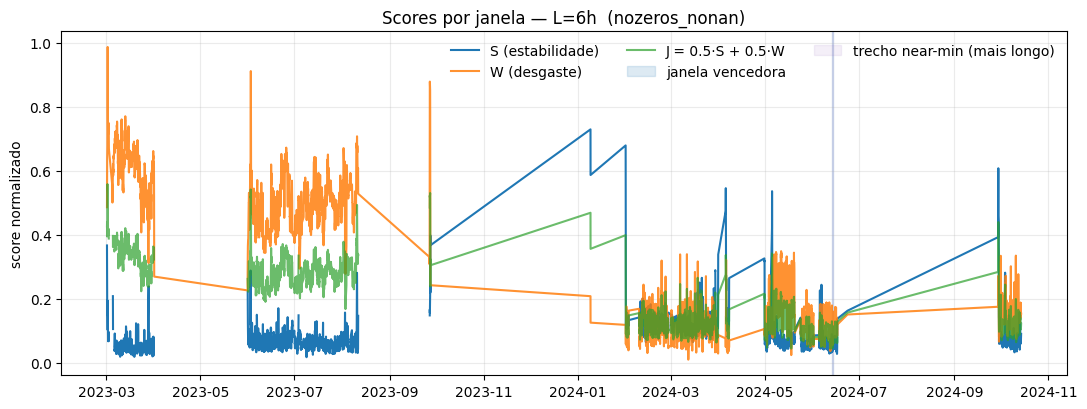

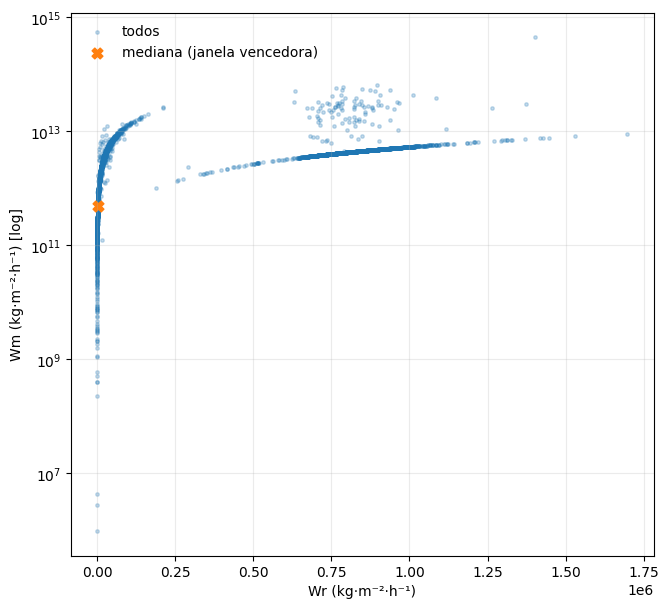

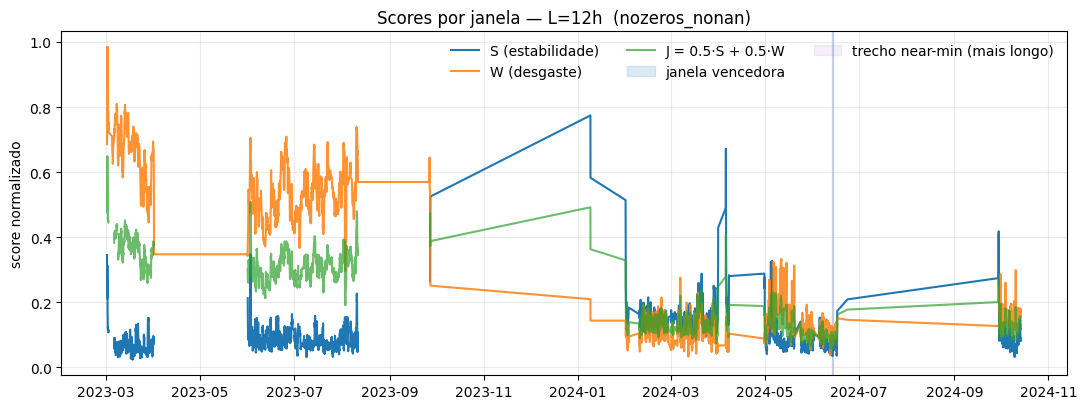

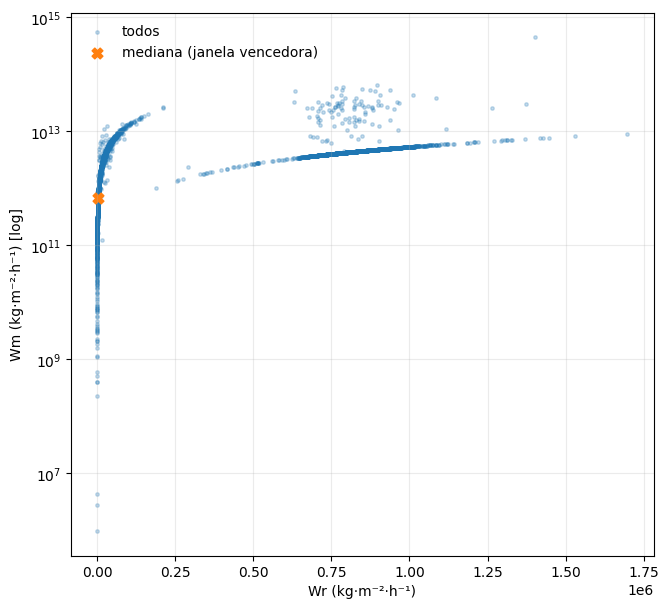

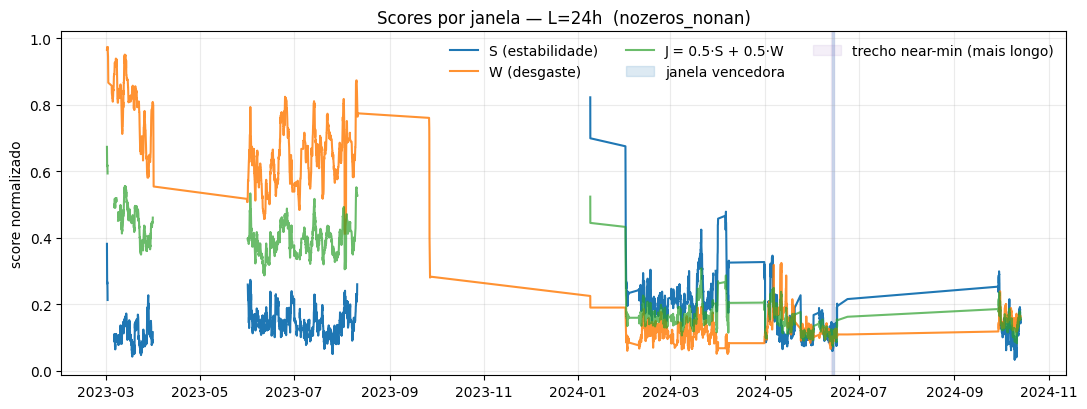

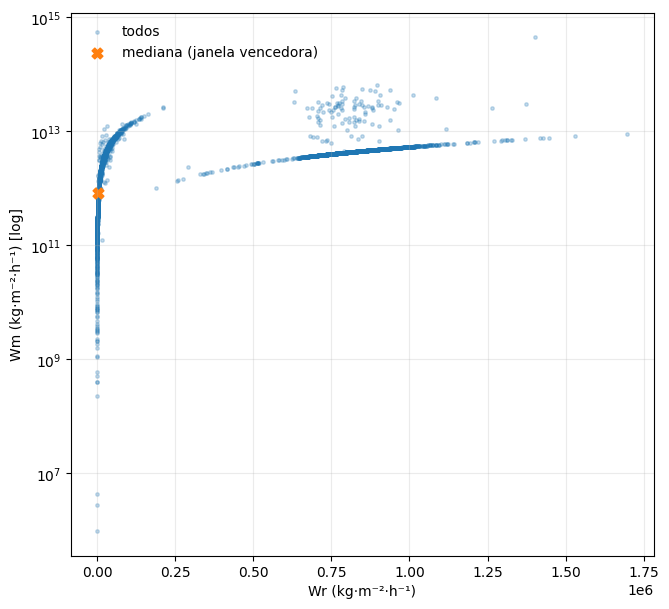

==== REFERÊNCIA — SUMÁRIO ====
Fonte: nozeros_nonan | C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\base_dados\A1_ML_DL_features_nozeros_nonan_20250818_1159.csv
Saídas em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\reference_selection

Escolha FINAL: L=6h
Janela vencedora: 2024-06-13 19:00:00  →  2024-06-14 00:00:00  |  n=6
Medianas: Wr̃=1930.887  Wm̃=489120796087.800
Trecho near-min (mais longo): 2024-06-13 17:00:00  →  2024-06-14 03:00:00  |  n=11

Arquivos gerados:
 - JSON: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\reference_selection\reference_period.json
 - CSV L=6h: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\reference_selection\reference_scores_L6h_nozeros_nonan.csv
 - CSV L=12h: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\reference_selectio

In [10]:
# ============================================================
# Referência Operacional: Estabilidade (S) + Baixo Desgaste (W)
# - Janelas L ∈ {6h, 12h, 24h}, stride=1 amostra
# - Estabilidade S = 0.4·Sv + 0.4·Sr + 0.2·Sc (robust / normalizado)
# - Desgaste W = 0.5·W_A(quantílico) + 0.5·W_B(Mahalanobis em (Wr, log10 Wm))
# - Seleção: S ≤ p10(S)  ⇒  minimize W  (guarda top-5 e o trecho contínuo mais longo)
# - Saídas: CSVs por L, consolidado, JSON com referência oficial, plots
# ============================================================
import os, re, glob, json, math, hashlib
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

# ------------------ PATHS / PARAMS ------------------
BASE = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE, "outputs", "freeze", "v1_20250818_0635")

# 1) tenta usar nozeros_nonan mais recente (nova_tratativa); 2) fallback: GOLD v4
CANDS_NOZ = glob.glob(os.path.join(BASE, "outputs", "nova_tratativa", "base_dados",
                                   "A1_ML_DL_features_nozeros_nonan_*.csv"))
if CANDS_NOZ:
    PATH_DATA = max(CANDS_NOZ, key=os.path.getmtime)
    DATA_KIND = "nozeros_nonan"
else:
    PATH_DATA = os.path.join(FREEZE_DIR, "A1_ML_DL_features_v4_gold.csv")
    DATA_KIND = "gold_v4"

OUT_DIR = os.path.join(FREEZE_DIR, "reference_selection")
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
os.makedirs(OUT_DIR, exist_ok=True); os.makedirs(PLOTS_DIR, exist_ok=True)

YCOLS = ["wr_kg_m2_h","wm_kg_m2_h"]
L_HOURS = [6, 12, 24]
WEIGHTS_S = (0.4, 0.4, 0.2)   # Sv, Sr, Sc
ALPHA_J   = 0.5               # J = alpha*S + (1-alpha)*W
EPS = 1e-9

# ------------------ LOAD ------------------
def read_csv_auto(path_csv: str) -> pd.DataFrame:
    # tenta multi-header (v4), senão header simples (nozeros_nonan)
    try:
        dfr = pd.read_csv(path_csv, header=[0,1], engine="python")
        df  = dfr.copy(); df.columns = [c for (c,_) in dfr.columns]
        return df
    except Exception:
        return pd.read_csv(path_csv)

df = read_csv_auto(PATH_DATA)

# timestamp (1a coluna que "parece" tempo)
def find_timecol(d: pd.DataFrame):
    for c in d.columns:
        if re.search(r"(time|hora|data|date|timestamp|datetime|ts)", str(c), re.I):
            s = pd.to_datetime(d[c], errors="coerce")
            if s.notna().mean() >= 0.5:
                return c, s
    return None, pd.Series(pd.NaT, index=d.index)
ts_name, ts = find_timecol(df)

# ordena temporalmente se possível
if ts_name:
    order = ts.argsort(kind="mergesort")
    df = df.iloc[order].reset_index(drop=True)
    ts = ts.iloc[order].reset_index(drop=True)

# alvos numéricos
for c in YCOLS:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    else:
        raise RuntimeError(f"Alvo ausente: {c}")

wr = df[YCOLS[0]].to_numpy(float)
wm = df[YCOLS[1]].to_numpy(float)

# amostragem
dt_med = (ts - ts.shift()).median() if ts_name else pd.Timedelta(hours=1)
dt_sec = max(1.0, dt_med.total_seconds() if pd.notna(dt_med) else 3600.0)

# ------------------ FEATURES INTERNAS ------------------
# usa todas numéricas que não são os alvos (dataset de features já é leak-guard)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
Xcols_all = [c for c in num_cols if c not in YCOLS]
X_all = df[Xcols_all].to_numpy(float)

# (opcional) se quiser restringir por "internas" por prefixo; ativa automaticamente só se
# encontrar número razoável de colunas:
pat = re.compile(r"^(temp|press|pressao|ar_|vent|flow|flw|corr|tiragem|o2_|so2_|dp_|p_|t_)", re.I)
Xcols_internas = [c for c in Xcols_all if pat.search(c)]
if len(Xcols_internas) >= max(10, int(0.2*len(Xcols_all))):
    Xcols = Xcols_internas
else:
    Xcols = Xcols_all  # fallback
X = df[Xcols].to_numpy(float)

# robust params (global) p/ padronização (mediana/IQR)
med = np.nanmedian(X, axis=0)
iqr = np.nanpercentile(X, 75, axis=0) - np.nanpercentile(X, 25, axis=0)
iqr[iqr < 1e-12] = 1e-12
def robust_z(x): return (x - med) / iqr

# ------------------ DESGASTE GLOBAL: quantis e "zona baixa" ------------------
wr_pos = wr[wr > 0]; wm_pos = wm[wm > 0]
if wr_pos.size < 30 or wm_pos.size < 30:
    raise RuntimeError("Poucos valores positivos de Wr/Wm para medidas globais — verifique a base.")

# quantílica (CDF) p/ positivos
wr_pos_sorted = np.sort(wr_pos); wm_pos_sorted = np.sort(wm_pos)
def cdf_pos(val, arr_sorted):
    # retorna fração <= val (entre 0 e 1)
    k = np.searchsorted(arr_sorted, val, side="right")
    return np.clip(k / max(1, arr_sorted.size), 0.0, 1.0)

# Zona-baixa p/ Mahalanobis em (Wr, log10 Wm)
thr_wr = np.percentile(wr_pos, 10)
thr_wm = np.percentile(wm_pos, 10)
mask_low = (wr <= thr_wr) & (wm > 0) & (wm <= thr_wm)
XY_low = np.vstack([wr[mask_low], np.log10(wm[mask_low]+EPS)]).T
if XY_low.shape[0] < 30:
    # fallback: usa todos os positivos
    XY_low = np.vstack([wr[wm>0], np.log10(wm[wm>0]+EPS)]).T
mu_low = XY_low.mean(axis=0)
S_low  = np.cov(XY_low, rowvar=False)
# regularização leve se mal-condicionado
cond = np.linalg.cond(S_low)
if not np.isfinite(cond) or cond > 1e8:
    lam = 1e-6 * np.trace(S_low) / 2.0
    S_low = S_low + lam * np.eye(2)
Sinv_low = np.linalg.pinv(S_low)

def maha2_pair(wr_val, wm_val):
    if not (wm_val > 0): return np.nan
    y = np.array([wr_val, math.log10(wm_val+EPS)])
    d = y - mu_low
    return float(d @ Sinv_low @ d.T)

# ------------------ VARREDURA DE JANELAS ------------------
def win_len_steps(L_h):
    steps = int(round((L_h*3600.0)/dt_sec))
    return max(3, steps)

def window_metrics_for_L(L_h):
    WN = win_len_steps(L_h)
    n = len(df)
    out = []
    for start in range(0, n - WN + 1):
        end = start + WN  # exclusivo
        # estabilidade nas internas (robust-z)
        Xw = X[start:end, :]
        Zw = robust_z(Xw)
        # Sv: MAD por variável, depois mediana entre variáveis
        mad_var = np.nanmedian(np.abs(Zw - np.nanmedian(Zw, axis=0)), axis=0)
        Sv = float(np.nanmedian(mad_var))
        # Sr: mediana de |Δx| por variável (no robust-z)
        if WN >= 2:
            dZw = np.abs(np.diff(Zw, axis=0))
            Sr = float(np.nanmedian(np.nanmedian(dZw, axis=0)))
        else:
            Sr = 0.0
        # Sc: compacidade (log det da cov)
        try:
            Cw = np.cov(Zw, rowvar=False)
            # regulariza se necessário
            condw = np.linalg.cond(Cw)
            if not np.isfinite(condw) or condw > 1e8:
                lam = 1e-6 * np.trace(Cw) / Zw.shape[1]
                Cw = Cw + lam * np.eye(Cw.shape[0])
            sign, logdet = np.linalg.slogdet(Cw)
            Sc = float(logdet if sign > 0 else np.nan)
        except Exception:
            Sc = np.nan

        # desgaste na janela (medianas)
        wr_m = float(np.nanmedian(wr[start:end]))
        wm_m = float(np.nanmedian(wm[start:end]))
        # W_A (quantílico): CDF dos positivos
        q_wr = cdf_pos(wr_m, wr_pos_sorted) if wr_m > 0 else 0.0
        q_wm = cdf_pos(wm_m, wm_pos_sorted) if wm_m > 0 else 0.0
        W_A = math.sqrt(q_wr * q_wm)
        # W_B (Mahalanobis²) em (Wr, log10 Wm) — normaliza depois
        W_B_d2 = maha2_pair(wr_m, wm_m)

        mid_ts = ts.iloc[start + (WN//2)] if ts_name else pd.NaT
        out.append({
            "L_hours": L_h,
            "start_idx": start, "end_idx": end-1,
            "start_ts": str(ts.iloc[start]) if ts_name else "",
            "end_ts":   str(ts.iloc[end-1]) if ts_name else "",
            "mid_ts":   str(mid_ts),
            "n": int(WN),
            "Sv": Sv, "Sr": Sr, "Sc": Sc,
            "wr_med": wr_m, "wm_med": wm_m,
            "W_A": W_A, "W_B_d2": W_B_d2
        })
    dfw = pd.DataFrame(out)

    # normalizações
    for k in ["Sv","Sr","Sc"]:
        a = dfw[k].to_numpy(float)
        mn, mx = np.nanmin(a), np.nanmax(a)
        dfw[k+"_n"] = (a - mn) / (mx - mn + EPS)

    # W_B: min-max nos d2 (ignora NaN)
    a = dfw["W_B_d2"].to_numpy(float)
    if np.isfinite(a).any():
        mn = np.nanmin(a[np.isfinite(a)])
        mx = np.nanmax(a[np.isfinite(a)])
        dfw["W_B_n"] = (a - mn) / (mx - mn + EPS)
    else:
        dfw["W_B_n"] = np.nan

    # S-score e W-score
    wv, wrg, wc = WEIGHTS_S
    dfw["S_score"] = wv*dfw["Sv_n"] + wrg*dfw["Sr_n"] + wc*dfw["Sc_n"]
    # se W_B_n não existir, cai só em W_A
    dfw["W_score"] = 0.5*dfw["W_A"] + 0.5*dfw["W_B_n"].fillna(dfw["W_A"])
    dfw["J_score"] = ALPHA_J*dfw["S_score"] + (1-ALPHA_J)*dfw["W_score"]
    return dfw

all_windows = []
for Lh in L_HOURS:
    dfw = window_metrics_for_L(Lh)
    all_windows.append(dfw)
df_all = pd.concat(all_windows, ignore_index=True)

# ------------------ SELEÇÃO / TOP-K ------------------
summary = {}
top_rows = []

for Lh in L_HOURS:
    dfl = df_all[df_all["L_hours"]==Lh].copy()
    if dfl.empty: continue
    thr_S = np.nanpercentile(dfl["S_score"], 10)  # melhor decil
    stable = dfl[dfl["S_score"] <= thr_S].copy()
    stable = stable.sort_values(["W_score","J_score","n"], ascending=[True, True, False]).reset_index(drop=True)
    best_row = stable.iloc[0].to_dict()

    # "quase melhores": W_score dentro de 2 p.p. do mínimo
    tol = 0.02
    near = stable[stable["W_score"] <= best_row["W_score"] + tol].copy()
    # agrega “trechos contínuos” (merge de janelas que se sobrepõem ou encostam)
    segs = []
    if not near.empty:
        intervals = near[["start_idx","end_idx"]].to_numpy(int)
        intervals = intervals[np.argsort(intervals[:,0])]
        cur_s, cur_e = intervals[0]
        for s,e in intervals[1:]:
            if s <= cur_e + 1:
                cur_e = max(cur_e, e)
            else:
                segs.append((cur_s, cur_e))
                cur_s, cur_e = s, e
        segs.append((cur_s, cur_e))
    # escolhe o segmento mais longo
    if segs:
        lens = [(e-s+1, s, e) for (s,e) in segs]
        lens.sort(reverse=True)
        best_seg_len, best_seg_s, best_seg_e = lens[0]
        best_seg = {
            "start_idx": int(best_seg_s),
            "end_idx": int(best_seg_e),
            "n": int(best_seg_len),
            "start_ts": str(ts.iloc[best_seg_s]) if ts_name else "",
            "end_ts":   str(ts.iloc[best_seg_e]) if ts_name else "",
        }
    else:
        best_seg = None

    summary[Lh] = {
        "thr_S_p10": float(thr_S),
        "best_window": {k: (v.item() if hasattr(v,"item") else v) for k,v in best_row.items()},
        "longest_near_segment": best_seg,
    }
    # guarda top-5 estáveis por L
    top_rows.append(stable.head(5).assign(rank=np.arange(1,6)))

# CSVs por L
for Lh in L_HOURS:
    path_csv = os.path.join(OUT_DIR, f"reference_scores_L{Lh}h_{DATA_KIND}.csv")
    df_all[df_all["L_hours"]==Lh].to_csv(path_csv, index=False)

# Consolidado (top-5 por L)
df_top = pd.concat(top_rows, ignore_index=True) if top_rows else pd.DataFrame()
PATH_TOP = os.path.join(OUT_DIR, f"reference_top5_by_L_{DATA_KIND}.csv")
df_top.to_csv(PATH_TOP, index=False)

# Escolha FINAL entre Ls: pega a janela com menor W_score (com S ≤ p10) e, em caso de empate, maior n
best_candidates = []
for Lh in L_HOURS:
    if Lh not in summary: continue
    bw = summary[Lh]["best_window"]
    best_candidates.append((bw["W_score"], -bw["n"], Lh, bw))
best_candidates.sort()
if best_candidates:
    _, _, Lh_chosen, bw_chosen = best_candidates[0]
else:
    Lh_chosen, bw_chosen = None, None

# Também guarda o segmento “near-min” mais longo do L escolhido (se houver)
seg_chosen = summary.get(Lh_chosen, {}).get("longest_near_segment", None) if Lh_chosen else None

# ------------------ JSON (referência oficial) ------------------
META_JSON = os.path.join(OUT_DIR, "reference_period.json")
meta = {
    "generated_at": datetime.now().isoformat(),
    "source_data": {"kind": DATA_KIND, "path": PATH_DATA},
    "ycols": YCOLS,
    "time_column": ts_name,
    "window_lengths_h": L_HOURS,
    "weights": {"S": WEIGHTS_S, "alpha_J": ALPHA_J},
    "low_zone": {
        "wr_p10": float(thr_wr), "wm_p10": float(thr_wm),
        "mu_wr_logwm": [float(mu_low[0]), float(mu_low[1])],
        "S_inv": [[float(x) for x in row] for row in Sinv_low.tolist()]
    },
    "per_L": summary,
    "final_choice": {
        "L_hours": Lh_chosen,
        "best_window": bw_chosen,
        "longest_near_segment": seg_chosen
    }
}
with open(META_JSON, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

# ------------------ PLOTS ------------------
def plot_timeline_scores(dfL, Lh, best_row, seg_best, out_png):
    # eixo x por mid_ts (se disponível)
    if "mid_ts" in dfL.columns and dfL["mid_ts"].notna().any():
        tx = pd.to_datetime(dfL["mid_ts"], errors="coerce")
    else:
        # fallback: índice
        tx = pd.RangeIndex(len(dfL))
    fig, ax = plt.subplots(figsize=(11, 4.2))
    ax.plot(tx, dfL["S_score"], label="S (estabilidade)")
    ax.plot(tx, dfL["W_score"], label="W (desgaste)", alpha=0.85)
    ax.plot(tx, dfL["J_score"], label="J = 0.5·S + 0.5·W", alpha=0.7)
    # destacar melhor janela e segmento “near”
    if best_row is not None:
        s = int(best_row["start_idx"]); e = int(best_row["end_idx"])
        s_ts = pd.to_datetime(best_row["start_ts"]) if best_row["start_ts"] else None
        e_ts = pd.to_datetime(best_row["end_ts"]) if best_row["end_ts"] else None
        if s_ts is not None and e_ts is not None:
            ax.axvspan(s_ts, e_ts, color="tab:blue", alpha=0.15, label="janela vencedora")
    if seg_best is not None and ts_name:
        s_ts = pd.to_datetime(seg_best["start_ts"])
        e_ts = pd.to_datetime(seg_best["end_ts"])
        ax.axvspan(s_ts, e_ts, color="tab:purple", alpha=0.10, label="trecho near-min (mais longo)")
    ax.set_title(f"Scores por janela — L={Lh}h  ({DATA_KIND})")
    ax.set_ylabel("score normalizado"); ax.grid(True, alpha=0.25)
    ax.legend(frameon=False, ncols=3)
    fig.tight_layout(); fig.savefig(out_png, dpi=150); plt.show()

def plot_scatter_wr_wm(dfL, best_row, out_png):
    # ponto da janela vencedora (medianas)
    fig, ax = plt.subplots(figsize=(6.8, 6.2))
    ax.scatter(wr, wm, s=6, alpha=0.25, label="todos")
    if best_row is not None:
        ax.scatter([best_row["wr_med"]], [best_row["wm_med"]], s=60, marker="X", label="mediana (janela vencedora)")
    ax.set_xscale("linear")
    ax.set_yscale("log")
    ax.set_xlabel("Wr (kg·m⁻²·h⁻¹)")
    ax.set_ylabel("Wm (kg·m⁻²·h⁻¹) [log]")
    ax.grid(True, which="both", alpha=0.25); ax.legend(frameon=False)
    fig.tight_layout(); fig.savefig(out_png, dpi=150); plt.show()

for Lh in L_HOURS:
    dfl = df_all[df_all["L_hours"]==Lh].copy()
    if dfl.empty: continue
    best = summary[Lh]["best_window"]
    seg  = summary[Lh]["longest_near_segment"]
    plot_timeline_scores(dfl, Lh, best, seg,
        os.path.join(PLOTS_DIR, f"timeline_scores_L{Lh}h_{DATA_KIND}.png"))
    plot_scatter_wr_wm(dfl, best,
        os.path.join(PLOTS_DIR, f"scatter_wr_wm_L{Lh}h_{DATA_KIND}.png"))

# ------------------ SUMÁRIO FINAL ------------------
print("==== REFERÊNCIA — SUMÁRIO ====")
print("Fonte:", DATA_KIND, "|", PATH_DATA)
print("Saídas em:", OUT_DIR)
if Lh_chosen:
    print(f"\nEscolha FINAL: L={Lh_chosen}h")
    print("Janela vencedora:",
          f"{bw_chosen['start_ts']}  →  {bw_chosen['end_ts']}  |  n={bw_chosen['n']}")
    print("Medianas: Wr̃={:.3f}  Wm̃={:.3f}".format(bw_chosen['wr_med'], bw_chosen['wm_med']))
    if seg_chosen:
        print("Trecho near-min (mais longo):",
              f"{seg_chosen['start_ts']}  →  {seg_chosen['end_ts']}  |  n={seg_chosen['n']}")
print("\nArquivos gerados:")
print(" - JSON:", META_JSON)
for Lh in L_HOURS:
    print(f" - CSV L={Lh}h:", os.path.join(OUT_DIR, f"reference_scores_L{Lh}h_{DATA_KIND}.csv"))
print(" - Top-5 por L:", PATH_TOP)
print(" - Plots:", PLOTS_DIR)


In [11]:
# ============================================================
# Cria dataset "dados_ref" com razões wr/wrref e wm/wmref
# Base: nozeros_nonan mais recente
# Ref: medianas (Wr̃, Wm̃) da janela vencedora em reference_period.json
# Saída: FREEZE_DIR/reference_selection/dados_ref.csv
# ============================================================
import os, glob, json
import numpy as np
import pandas as pd
from datetime import datetime

BASE = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE, "outputs", "freeze", "v1_20250818_0635")
REF_DIR = os.path.join(FREEZE_DIR, "reference_selection")
OUT_CSV = os.path.join(REF_DIR, "dados_ref.csv")

# 1) carrega referência
REF_JSON = os.path.join(REF_DIR, "reference_period.json")
with open(REF_JSON, "r", encoding="utf-8") as f:
    ref = json.load(f)

bw = ref["final_choice"]["best_window"]
wr_ref = float(bw["wr_med"])
wm_ref = float(bw["wm_med"])

if not (wr_ref > 0 and wm_ref > 0):
    raise RuntimeError(f"Medianas inválidas para referência: wr_ref={wr_ref}, wm_ref={wm_ref}")

# 2) pega a base nozeros_nonan mais recente
IN_DIR = os.path.join(BASE, "outputs", "nova_tratativa", "base_dados")
cands = glob.glob(os.path.join(IN_DIR, "A1_ML_DL_features_nozeros_nonan_*.csv"))
if not cands:
    raise FileNotFoundError("Não encontrei A1_ML_DL_features_nozeros_nonan_*.csv em " + IN_DIR)
SRC = max(cands, key=os.path.getmtime)

# 3) carrega DF (header simples — foi salvo flatten)
df = pd.read_csv(SRC)
# garante alvos numéricos
df["wr_kg_m2_h"] = pd.to_numeric(df["wr_kg_m2_h"], errors="coerce")
df["wm_kg_m2_h"] = pd.to_numeric(df["wm_kg_m2_h"], errors="coerce")

# 4) cria colunas de razão (em relação às medianas da referência)
df["wr/wrref"] = df["wr_kg_m2_h"] / wr_ref
df["wm/wmref"] = df["wm_kg_m2_h"] / wm_ref

# (opcional) anexa metadados úteis como atributos (não vão para o CSV)
df.attrs["ref_window"] = {
    "L_hours": ref["final_choice"]["L_hours"],
    "start_ts": bw["start_ts"],
    "end_ts": bw["end_ts"],
    "wr_med": wr_ref,
    "wm_med": wm_ref,
    "source_csv": SRC,
    "generated_at": datetime.now().isoformat()
}

# 5) salva
os.makedirs(REF_DIR, exist_ok=True)
df.to_csv(OUT_CSV, index=False)

print("== dados_ref gerado ==")
print("Fonte da base: ", SRC)
print("Wr_ref (mediana):", wr_ref)
print("Wm_ref (mediana):", wm_ref)
print("Saída:           ", OUT_CSV)
print("\nAmostra das novas colunas:")
print(df[["wr_kg_m2_h","wm_kg_m2_h","wr/wrref","wm/wmref"]].head(10))


== dados_ref gerado ==
Fonte da base:  C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\nova_tratativa\base_dados\A1_ML_DL_features_nozeros_nonan_20250818_1159.csv
Wr_ref (mediana): 1930.8867592468164
Wm_ref (mediana): 489120796087.8003
Saída:            C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\reference_selection\dados_ref.csv

Amostra das novas colunas:
     wr_kg_m2_h    wm_kg_m2_h    wr/wrref   wm/wmref
0  2.706614e+05  1.457298e+12  140.174640   2.979423
1  2.600705e+05  1.402225e+12  134.689656   2.866827
2  3.972370e+05  2.129607e+12  205.727750   4.353950
3  8.528101e+05  4.569641e+12  441.667606   9.342561
4  7.328063e+05  3.918914e+12  379.517994   8.012161
5  1.086246e+06  5.803377e+12  562.563193  11.864915
6  8.983887e+05  4.791324e+12  465.272617   9.795789
7  9.071366e+05  4.833475e+12  469.803118   9.881966
8  7.839634e+05  2.989644e+13  406.012087  61.122807
9  9.029977e+05  4.821068e+12  467.659

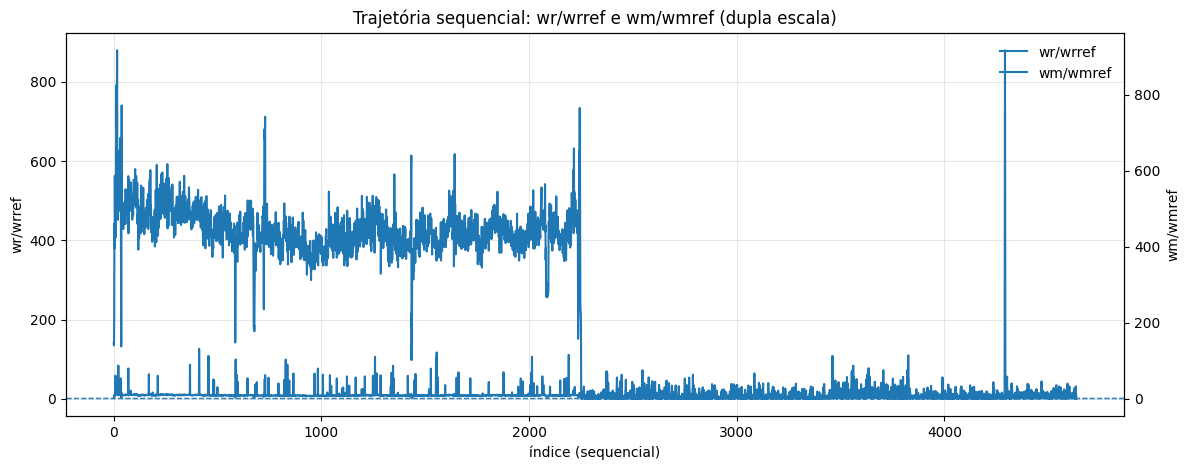

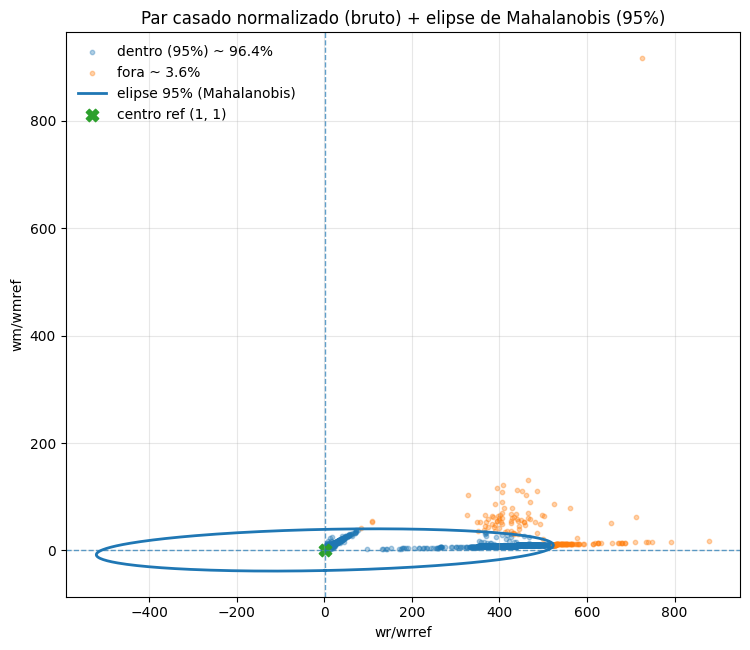

Resumo:
- Centro de referência usado: (wr/wrref, wm/wmref) = (1.0, 1.0)
- Percentual dentro da elipse 95%: 96.44% | fora: 3.56%


In [12]:
# ============================================
# Séries em dupla escala (wr/wrref, wm/wmref)
# + Scatter (wr/wrref vs wm/wmref) com elipse de Mahalanobis (95%)
# Centro da elipse: (1, 1)
# ============================================
import os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE, "outputs", "freeze", "v1_20250818_0635")
REF_DIR = os.path.join(FREEZE_DIR, "reference_selection")
PATH_REFJSON = os.path.join(REF_DIR, "reference_period.json")
PATH_DADOS   = os.path.join(REF_DIR, "dados_ref.csv")

# --- carga
with open(PATH_REFJSON, "r", encoding="utf-8") as f:
    ref = json.load(f)
wr_ref = float(ref["final_choice"]["best_window"]["wr_med"])
wm_ref = float(ref["final_choice"]["best_window"]["wm_med"])

df = pd.read_csv(PATH_DADOS)
for c in ["wr_kg_m2_h","wm_kg_m2_h","wr/wrref","wm/wmref"]:
    if c not in df.columns:
        raise RuntimeError(f"Coluna ausente: {c}")

wr_ratio = pd.to_numeric(df["wr/wrref"], errors="coerce").to_numpy()
wm_ratio = pd.to_numeric(df["wm/wmref"], errors="coerce").to_numpy()

# ================= FIG 1: trajetória sequencial (dupla escala) =================
plt.figure(figsize=(12,4.8))
ax = plt.gca()
ax.plot(wr_ratio, label="wr/wrref")
ax.axhline(1.0, linestyle="--", linewidth=1, alpha=0.7)  # referência
ax.set_xlabel("índice (sequencial)")
ax.set_ylabel("wr/wrref")
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
ax2.plot(wm_ratio, label="wm/wmref")
ax2.axhline(1.0, linestyle="--", linewidth=1, alpha=0.7)
ax2.set_ylabel("wm/wmref")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, frameon=False, loc="upper right")

plt.title("Trajetória sequencial: wr/wrref e wm/wmref (dupla escala)")
plt.tight_layout()
# plt.savefig(os.path.join(REF_DIR, "trajetoria_wr_wm_ref_sem_log.png"), dpi=150)
plt.show()

# ================= FIG 2: scatter bruto + elipse de Mahalanobis (95%) =================
# Espaço: (wr/wrref, wm/wmref), centro de referência = (1, 1)
X = np.vstack([wr_ratio, wm_ratio]).T
mu = np.array([1.0, 1.0])

# covariância com regularização leve se mal-condicionada
S = np.cov(X, rowvar=False)
cond = np.linalg.cond(S)
if not np.isfinite(cond) or cond > 1e8:
    lam = 1e-6 * np.trace(S) / 2.0
    S = S + lam * np.eye(2)
S_inv = np.linalg.pinv(S)

def maha2(x):
    d = x - mu
    return float(d @ S_inv @ d.T)

d2 = np.array([maha2(x) for x in X])
chi2_95 = 5.991  # qui-quadrado df=2, 95%
inside = d2 <= chi2_95
pct_in = 100.0 * inside.mean()
pct_out = 100.0 - pct_in

def ellipse_points(mu, S, level_d2, n=300):
    vals, vecs = np.linalg.eigh(S)
    t = np.linspace(0, 2*np.pi, n)
    circle = np.stack([np.cos(t), np.sin(t)], axis=0)
    L = np.diag(np.sqrt(vals * level_d2))
    pts = (vecs @ L @ circle).T + mu
    return pts

ell = ellipse_points(mu, S, chi2_95)

plt.figure(figsize=(7.6,6.6))
# pinta pontos dentro/fora (opcional)
plt.scatter(X[ inside,0], X[ inside,1], s=10, alpha=0.35, label=f"dentro (95%) ~ {pct_in:.1f}%")
plt.scatter(X[~inside,0], X[~inside,1], s=10, alpha=0.35, label=f"fora ~ {pct_out:.1f}%")
plt.plot(ell[:,0], ell[:,1], linewidth=2, label="elipse 95% (Mahalanobis)")
plt.scatter([mu[0]], [mu[1]], marker="X", s=80, label="centro ref (1, 1)")

# linhas de referência
plt.axvline(1.0, linestyle="--", linewidth=1, alpha=0.7)
plt.axhline(1.0, linestyle="--", linewidth=1, alpha=0.7)

plt.xlabel("wr/wrref")
plt.ylabel("wm/wmref")
plt.title("Par casado normalizado (bruto) + elipse de Mahalanobis (95%)")
plt.grid(True, which="both", alpha=0.3)
plt.legend(frameon=False, loc="best")
plt.tight_layout()
# plt.savefig(os.path.join(REF_DIR, "scatter_wr_wm_ref_ellipse95_sem_log.png"), dpi=150)
plt.show()

print("Resumo:")
print(f"- Centro de referência usado: (wr/wrref, wm/wmref) = (1.0, 1.0)")
print(f"- Percentual dentro da elipse 95%: {pct_in:.2f}% | fora: {pct_out:.2f}%")


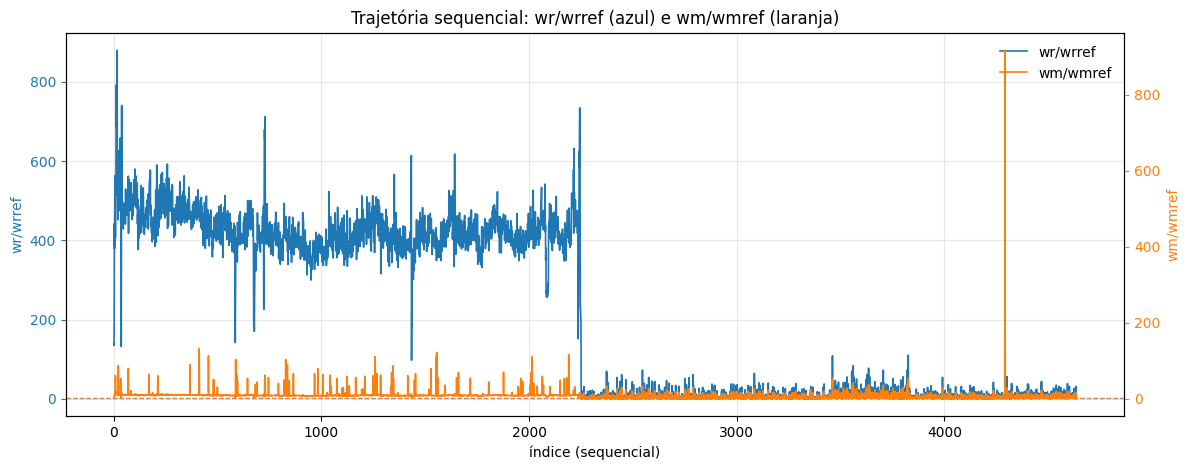

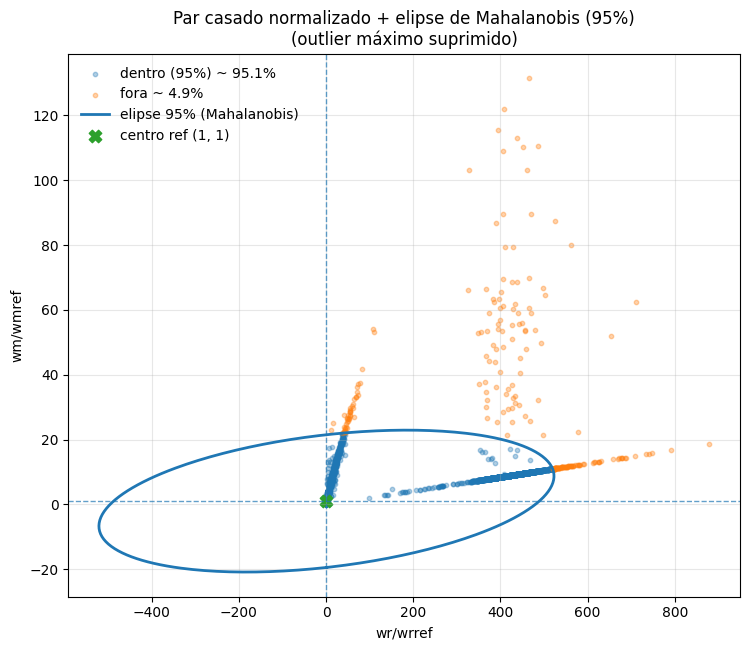

Resumo (scatter):
- Ponto suprimido (índice no conjunto válido): 4292
- Percentual dentro da elipse 95% (sem o outlier máximo): 95.08% | fora: 4.92%


In [13]:
# ============================================================
# Séries (dupla escala, cores distintas) + Scatter com elipse 95%
# Suprime o ponto mais extremo no scatter (maior distância de Mahalanobis)
# ============================================================
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt

BASE = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE, "outputs", "freeze", "v1_20250818_0635")
REF_DIR = os.path.join(FREEZE_DIR, "reference_selection")
PATH_DADOS   = os.path.join(REF_DIR, "dados_ref.csv")
PATH_REFJSON = os.path.join(REF_DIR, "reference_period.json")

# --- carga
with open(PATH_REFJSON, "r", encoding="utf-8") as f:
    ref = json.load(f)
df = pd.read_csv(PATH_DADOS)

wr_ratio = pd.to_numeric(df["wr/wrref"], errors="coerce").to_numpy()
wm_ratio = pd.to_numeric(df["wm/wmref"], errors="coerce").to_numpy()

# ================= FIG 1: trajetória sequencial (dupla escala, cores) =================
plt.figure(figsize=(12,4.8))
ax1 = plt.gca()
ln1, = ax1.plot(wr_ratio, color="tab:blue",  linewidth=1.2, label="wr/wrref")
ax1.axhline(1.0, color="tab:blue",  linestyle="--", linewidth=0.9, alpha=0.7)
ax1.set_xlabel("índice (sequencial)")
ax1.set_ylabel("wr/wrref", color="tab:blue")
ax1.tick_params(axis='y', colors="tab:blue")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ln2, = ax2.plot(wm_ratio, color="tab:orange", linewidth=1.2, label="wm/wmref")
ax2.axhline(1.0, color="tab:orange", linestyle="--", linewidth=0.9, alpha=0.7)
ax2.set_ylabel("wm/wmref", color="tab:orange")
ax2.tick_params(axis='y', colors="tab:orange")

# legenda combinada
ax1.legend([ln1, ln2], ["wr/wrref", "wm/wmref"], frameon=False, loc="upper right")
plt.title("Trajetória sequencial: wr/wrref (azul) e wm/wmref (laranja)")
plt.tight_layout()
# plt.savefig(os.path.join(REF_DIR, "trajetoria_dupla_escala_ref.png"), dpi=150)
plt.show()

# ================= FIG 2: scatter bruto + elipse de Mahalanobis (95%) =================
# Espaço: (wr/wrref, wm/wmref), centro (1,1). Suprime o ponto mais extremo.
X0 = np.vstack([wr_ratio, wm_ratio]).T
mask_finite = np.isfinite(X0).all(axis=1)
X0 = X0[mask_finite]

mu = np.array([1.0, 1.0])

# função auxiliar
def maha_d2_matrix(X, mu, S_inv):
    D = X - mu
    return np.einsum("ij,jk,ik->i", D, S_inv, D)

# 1) estima covariância nos dados completos e calcula distâncias
S_all = np.cov(X0, rowvar=False)
# regularização leve se mal-condicionado
cond = np.linalg.cond(S_all)
if not np.isfinite(cond) or cond > 1e8:
    lam = 1e-6 * np.trace(S_all) / 2.0
    S_all = S_all + lam * np.eye(2)
S_all_inv = np.linalg.pinv(S_all)
d2_all = maha_d2_matrix(X0, mu, S_all_inv)

# índice do ponto mais extremo
idx_outlier = int(np.nanargmax(d2_all))
X = np.delete(X0, idx_outlier, axis=0)  # suprime o mais extremo

# 2) reestima covariância sem o outlier e recalcula distâncias
S = np.cov(X, rowvar=False)
cond = np.linalg.cond(S)
if not np.isfinite(cond) or cond > 1e8:
    lam = 1e-6 * np.trace(S) / 2.0
    S = S + lam * np.eye(2)
S_inv = np.linalg.pinv(S)
d2 = maha_d2_matrix(X, mu, S_inv)

chi2_95 = 5.991  # df=2, 95%
inside = d2 <= chi2_95
pct_in  = 100.0 * inside.mean()
pct_out = 100.0 - pct_in

# pontos da elipse de nível (d2 = chi2_95)
def ellipse_points(mu, S, level_d2, n=300):
    vals, vecs = np.linalg.eigh(S)
    t = np.linspace(0, 2*np.pi, n)
    circle = np.stack([np.cos(t), np.sin(t)], axis=0)
    L = np.diag(np.sqrt(vals * level_d2))
    return (vecs @ L @ circle).T + mu

ell = ellipse_points(mu, S, chi2_95)

plt.figure(figsize=(7.6,6.6))
plt.scatter(X[ inside,0], X[ inside,1], s=10, alpha=0.35, label=f"dentro (95%) ~ {pct_in:.1f}%")
plt.scatter(X[~inside,0], X[~inside,1], s=10, alpha=0.35, label=f"fora ~ {pct_out:.1f}%")
plt.plot(ell[:,0], ell[:,1], linewidth=2, label="elipse 95% (Mahalanobis)")
plt.scatter([mu[0]], [mu[1]], marker="X", s=80, label="centro ref (1, 1)")

# linhas de referência
plt.axvline(1.0, linestyle="--", linewidth=1, alpha=0.7)
plt.axhline(1.0, linestyle="--", linewidth=1, alpha=0.7)

plt.xlabel("wr/wrref")
plt.ylabel("wm/wmref")
plt.title("Par casado normalizado + elipse de Mahalanobis (95%)\n(outlier máximo suprimido)")
plt.grid(True, which="both", alpha=0.3)
plt.legend(frameon=False, loc="best")
plt.tight_layout()
# plt.savefig(os.path.join(REF_DIR, "scatter_maha95_clean1.png"), dpi=150)
plt.show()

print("Resumo (scatter):")
print(f"- Ponto suprimido (índice no conjunto válido): {idx_outlier}")
print(f"- Percentual dentro da elipse 95% (sem o outlier máximo): {pct_in:.2f}% | fora: {pct_out:.2f}%")


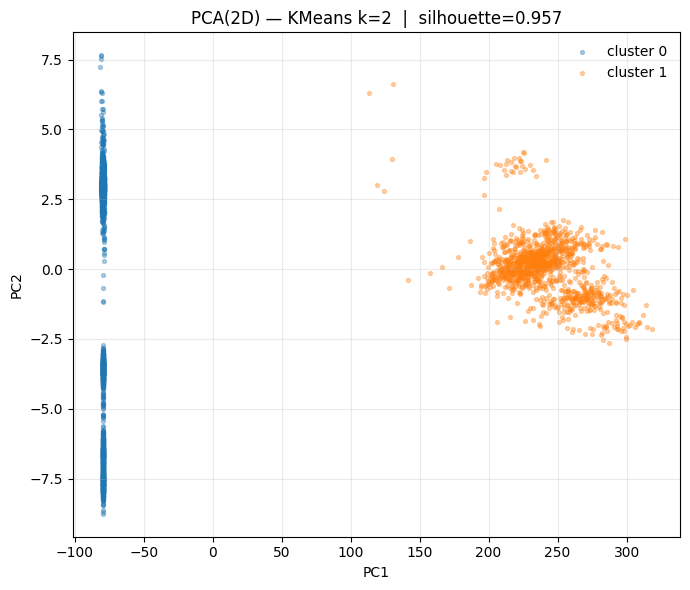

== RESULTADOS ==
Silhouette: 0.957
Colunas internas iniciais: 83
Removidas por missing >= 40%: 0
Removidas por variância ~0: 0
Usadas no clustering: 83

Resumo por cluster:
 cluster    n  wr/wrref_med  wm/wmref_med
       0 3483    391.620828      8.579573
       1 1153      3.334338      2.590304

Top 10 variáveis mais distintas:
                            feature  median_c0  median_c1  delta_median  abs_delta_over_IQR  ks_stat  mutual_info  rank_combined
        pressao_ar_sec_vent_a_saida     10.934   1333.133      1322.199           19.178078 1.000000     0.561017       1.000000
       temp_no_8_hp_heater_feed_wtr    278.282    251.155       -27.127            2.797463 0.798725     0.392876       5.000000
       temp_no_6_hp_heater_feed_wtr    223.573    149.625       -73.948            2.118793 0.802751     0.364432       6.666667
pressao_ar_flu_ap_vent_c_saida_head      0.233     95.029        94.796            2.113081 0.810891     0.355491       7.666667
       temp_no_7_hp_he

In [15]:
# ============================================================
# K=2 com tratamento de NaNs
# - Drop de colunas com missing >= 40% (ajustável)
# - Imputação por mediana nas demais
# - Robust-z (mediana/IQR) e KMeans(k=2)
# - Comparativo de variáveis + artefatos salvos
# ============================================================
import os, re, json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Fallback de KS (sem SciPy)
def ks_2samp_np(a, b):
    a = np.sort(a[~np.isnan(a)])
    b = np.sort(b[~np.isnan(b)])
    if a.size == 0 or b.size == 0:
        return np.nan
    allv = np.concatenate([a, b])
    ia = np.searchsorted(a, allv, side="right")
    ib = np.searchsorted(b, allv, side="right")
    da = ia / a.size
    db = ib / b.size
    return float(np.max(np.abs(da - db)))

# ---------- PATHS ----------
BASE = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE, "outputs", "freeze", "v1_20250818_0635")
REF_DIR = os.path.join(FREEZE_DIR, "reference_selection")
IN_CSV  = os.path.join(REF_DIR, "dados_ref.csv")
OUT_DIR = os.path.join(REF_DIR, "cluster2")
PLOT_DIR = os.path.join(OUT_DIR, "plots")
os.makedirs(OUT_DIR, exist_ok=True); os.makedirs(PLOT_DIR, exist_ok=True)

# ---------- CARREGA ----------
df = pd.read_csv(IN_CSV)
YCOLS = ["wr_kg_m2_h","wm_kg_m2_h","wr/wrref","wm/wmref"]

def find_timecol(d: pd.DataFrame):
    for c in d.columns:
        if re.search(r"(time|hora|data|date|timestamp|datetime|ts)", str(c), re.I):
            s = pd.to_datetime(d[c], errors="coerce")
            if s.notna().mean() >= 0.5:
                return c
    return None
ts_col_name = find_timecol(df)

# ---------- FEATURES INTERNAS ----------
num_cols   = df.select_dtypes(include=[np.number]).columns.tolist()
Xcols_all  = [c for c in num_cols if c not in YCOLS]

pat = re.compile(r"^(temp|press|pressao|ar_|vent|flow|flw|corr|tiragem|o2_|so2_|dp_|p_|t_)", re.I)
Xcols_int  = [c for c in Xcols_all if pat.search(c)]
Xcols      = Xcols_int if len(Xcols_int) >= max(10, int(0.2*len(Xcols_all))) else Xcols_all

# ---------- MISSING: DROP + IMPUTAÇÃO ----------
MISSING_COL_MAX = 0.40  # limiar para descartar coluna (40% ou mais de NaN)
miss_rate = df[Xcols].isna().mean().sort_values(ascending=False)

drop_cols = miss_rate[miss_rate >= MISSING_COL_MAX].index.tolist()
keep_cols = [c for c in Xcols if c not in drop_cols]

# remove colunas completamente NaN ou constantes após imputação
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(df[keep_cols])

# descarta colunas constantes (variância ~ 0 após imputar)
X_imp_df = pd.DataFrame(X_imp, columns=keep_cols)
var_ = X_imp_df.var(axis=0, ddof=0)
const_cols = var_[var_ <= 1e-12].index.tolist()

# colunas finais
final_cols = [c for c in keep_cols if c not in const_cols]
X_imp_final = X_imp_df[final_cols].to_numpy()

# ---------- ROBUST-Z ----------
med = np.nanmedian(X_imp_final, axis=0)
iqr = np.nanpercentile(X_imp_final, 75, axis=0) - np.nanpercentile(X_imp_final, 25, axis=0)
iqr[iqr < 1e-12] = 1.0  # evita divisão por ~0
Xz = (X_imp_final - med) / iqr

# ---------- KMEANS (k=2) ----------
k = 2
km = KMeans(n_clusters=k, n_init=20, random_state=42)
labels = km.fit_predict(Xz)
sil = silhouette_score(Xz, labels)

# ---------- SUMÁRIOS POR CLUSTER ----------
def q(x, p):
    x = np.asarray(x, float); x = x[~np.isnan(x)]
    return float(np.percentile(x, p)) if x.size else np.nan

df_lab = pd.DataFrame({
    "cluster": labels,
    "wr": pd.to_numeric(df["wr_kg_m2_h"], errors="coerce"),
    "wm": pd.to_numeric(df["wm_kg_m2_h"], errors="coerce"),
    "wr/wrref": pd.to_numeric(df["wr/wrref"], errors="coerce"),
    "wm/wmref": pd.to_numeric(df["wm/wmref"], errors="coerce"),
})
if ts_col_name:
    df_lab["timestamp"] = pd.to_datetime(df[ts_col_name], errors="coerce")

summ_rows = []
for c in range(k):
    g = df_lab[df_lab["cluster"]==c]
    summ_rows.append({
        "cluster": c,
        "n": int(len(g)),
        "wr_med": q(g["wr"],50), "wr_p10": q(g["wr"],10), "wr_p90": q(g["wr"],90),
        "wm_med": q(g["wm"],50), "wm_p10": q(g["wm"],10), "wm_p90": q(g["wm"],90),
        "wr/wrref_med": q(g["wr/wrref"],50),
        "wm/wmref_med": q(g["wm/wmref"],50),
    })
df_summary = pd.DataFrame(summ_rows)

# ---------- DIFERENÇAS POR VARIÁVEL ----------
res = []
lab = labels
for col in final_cols:
    x0 = pd.to_numeric(df.loc[lab==0, col], errors="coerce").to_numpy()
    x1 = pd.to_numeric(df.loc[lab==1, col], errors="coerce").to_numpy()
    med0, med1 = q(x0,50), q(x1,50)
    iqr0 = q(x0,75) - q(x0,25)
    iqr1 = q(x1,75) - q(x1,25)
    iqr_pool = np.nanmedian([iqr0, iqr1]) if np.isfinite(iqr0) and np.isfinite(iqr1) else np.nan
    d_med = med1 - med0
    eff = abs(d_med) / (iqr_pool if (iqr_pool and iqr_pool>0) else np.nan)
    ks = ks_2samp_np(x0, x1)
    res.append([col, med0, med1, d_med, eff, ks])

df_diff = pd.DataFrame(res, columns=["feature","median_c0","median_c1","delta_median","abs_delta_over_IQR","ks_stat"])

# mutual information (no dado imputado já filtrado)
Xi = X_imp_df[final_cols].to_numpy()
mi = mutual_info_classif(Xi, lab, discrete_features=False, random_state=42)
df_diff["mutual_info"] = mi

# ranking combinado
def rank_desc(s): 
    return s.rank(ascending=False, method="min")
r_eff = rank_desc(df_diff["abs_delta_over_IQR"].fillna(0))
r_ks  = rank_desc(df_diff["ks_stat"].fillna(0))
r_mi  = rank_desc(df_diff["mutual_info"].fillna(0))
df_diff["rank_combined"] = (r_eff + r_ks + r_mi) / 3.0
df_diff = df_diff.sort_values("rank_combined").reset_index(drop=True)
df_top = df_diff.head(20).copy()

# ---------- PCA PLOT ----------
pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(Xz)
plt.figure(figsize=(7,6))
plt.scatter(Xp[lab==0,0], Xp[lab==0,1], s=8, alpha=0.35, label="cluster 0")
plt.scatter(Xp[lab==1,0], Xp[lab==1,1], s=8, alpha=0.35, label="cluster 1")
plt.title(f"PCA(2D) — KMeans k=2  |  silhouette={sil:.3f}")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True, alpha=0.25); plt.legend(frameon=False)
plt.tight_layout()
plot_path = os.path.join(PLOT_DIR, "pca2_k2.png")
plt.savefig(plot_path, dpi=140); plt.show()

# ---------- SAVE ----------
TAG = datetime.now().strftime("%Y%m%d_%H%M")
PATH_LABELS  = os.path.join(OUT_DIR, f"labels_k2_{TAG}.csv")
PATH_DIFF    = os.path.join(OUT_DIR, f"diffvars_k2_{TAG}.csv")
PATH_CENTS   = os.path.join(OUT_DIR, f"centroids_k2_{TAG}.csv")
PATH_SUMMARY = os.path.join(OUT_DIR, f"summary_k2_{TAG}.md")

cols_keep = ["cluster","wr","wm","wr/wrref","wm/wmref"]
if ts_col_name: cols_keep = ["timestamp"] + cols_keep
df_lab[cols_keep].to_csv(PATH_LABELS, index=False)
df_diff.to_csv(PATH_DIFF, index=False)

# centróides = medianas por cluster (só internas finais)
cent_rows = []
for c in range(k):
    g = df[df_lab["cluster"]==c]
    cent = {"cluster": c}
    for col in final_cols:
        cent[col] = q(pd.to_numeric(g[col], errors="coerce"), 50)
    cent_rows.append(cent)
pd.DataFrame(cent_rows).to_csv(PATH_CENTS, index=False)

with open(PATH_SUMMARY, "w", encoding="utf-8") as f:
    f.write(f"""# KMeans (k=2) — Dois universos (com tratamento de NaNs)
**Gerado em**: {datetime.now().isoformat()}
**Base**: {IN_CSV}
**Silhouette**: {sil:.4f}

## Higienização
- Colunas candidatas (internas): {len(Xcols)}
- Removidas por missing >= {int(MISSING_COL_MAX*100)}%: {len(drop_cols)}
- Removidas por variância ~0 (constantes): {len(const_cols)}
- Usadas no clustering: {len(final_cols)}

Top 10 colunas com maior missing (original):
{miss_rate.head(10).to_string()}

## Tamanho dos clusters
{pd.DataFrame({'cluster':[0,1], 'n':[ (labels==0).sum(), (labels==1).sum() ]}).to_string(index=False)}

## WR/WM por cluster (medianas)
{pd.DataFrame(summ_rows)[['cluster','wr_med','wm_med','wr/wrref_med','wm/wmref_med']].to_string(index=False)}

## Top 20 variáveis mais distintas (ranking combinado)
{df_top[['feature','delta_median','abs_delta_over_IQR','ks_stat','mutual_info','rank_combined']].to_string(index=False)}

(Arquivos:)
- Labels: {PATH_LABELS}
- Diferenças: {PATH_DIFF}
- Centróides: {PATH_CENTS}
- PCA plot: {plot_path}
""")

print("== RESULTADOS ==")
print(f"Silhouette: {sil:.3f}")
print(f"Colunas internas iniciais: {len(Xcols)}")
print(f"Removidas por missing >= {int(MISSING_COL_MAX*100)}%: {len(drop_cols)}")
print(f"Removidas por variância ~0: {len(const_cols)}")
print(f"Usadas no clustering: {len(final_cols)}")
print("\nResumo por cluster:")
print(pd.DataFrame(summ_rows)[['cluster','n','wr/wrref_med','wm/wmref_med']].to_string(index=False))
print("\nTop 10 variáveis mais distintas:")
print(df_top.head(10).to_string(index=False))
print("\nArquivos salvos em:", OUT_DIR)
print(" - labels:", PATH_LABELS)
print(" - diffs :", PATH_DIFF)
print(" - cents :", PATH_CENTS)
print(" - resumo:", PATH_SUMMARY)
print(" - plot  :", plot_path)


Silhouette: 0.957
 cluster    n  wr/wrref_med  wm/wmref_med
       0 3483    391.620828      8.579573
       1 1153      3.334338      2.590304


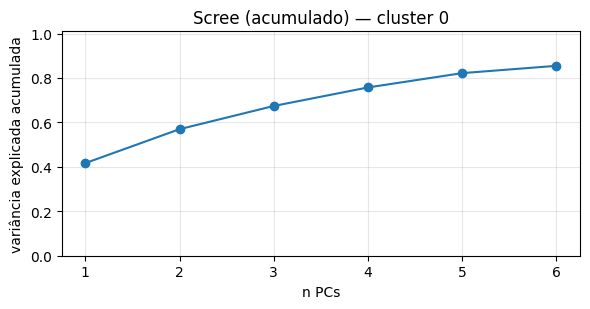

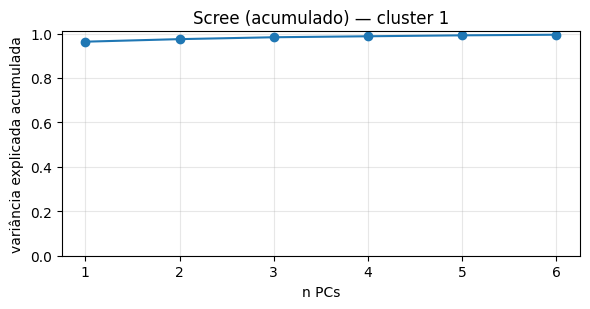

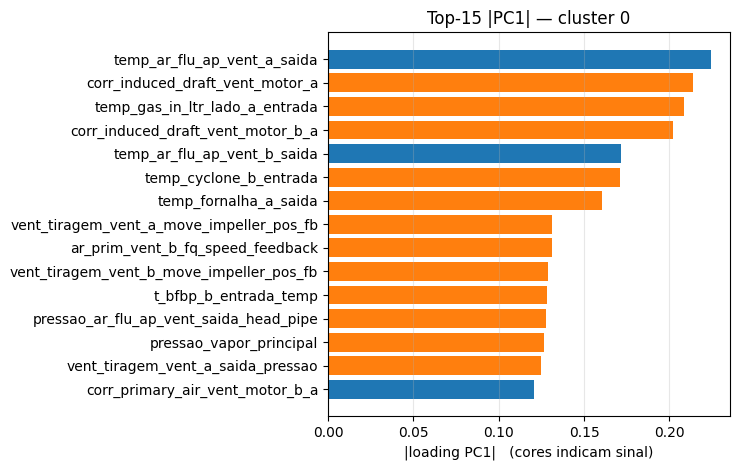

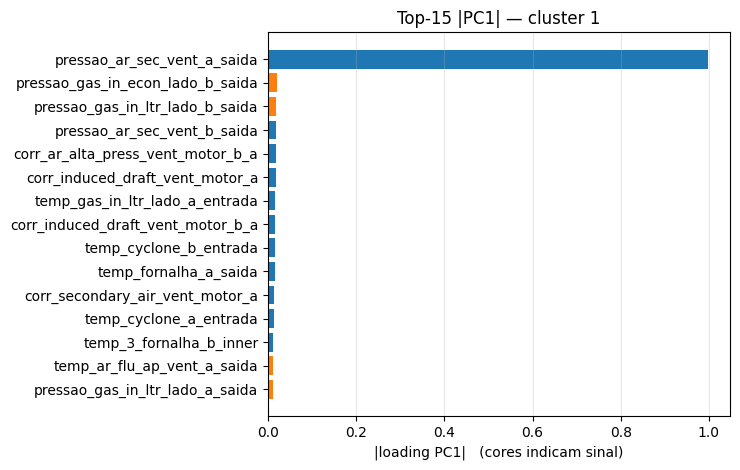


Top-15 |PC1| por cluster salvos em:
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\reference_selection\cluster2\plots\pca_top15_pc1_c0_20250818_1809.png
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\reference_selection\cluster2\plots\pca_top15_pc1_c1_20250818_1809.png
Loadings completos:
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\reference_selection\cluster2\pca_loadings_cluster0_20250818_1809.csv
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\reference_selection\cluster2\pca_loadings_cluster1_20250818_1809.csv
Tabela de diferenças atualizada:
 - C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\freeze\v1_20250818_0635\reference_selection\cluster2\diffvars_k2_20250818_1809.csv

Pistas rápidas de interpretação:
• PC1 do cluster 0 ≈ eixo de maior variabilidade inter

In [16]:
# ============================================================
# PCA por cluster (k=2) + principais diferenças
# Base: FREEZE_DIR/reference_selection/dados_ref.csv
# Saídas: FREEZE_DIR/reference_selection/cluster2/*
# ============================================================
import os, re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif

# KS simples sem SciPy
def ks_2samp_np(a, b):
    a = np.sort(a[~np.isnan(a)]); b = np.sort(b[~np.isnan(b)])
    if a.size==0 or b.size==0: return np.nan
    allv = np.concatenate([a,b])
    ia = np.searchsorted(a, allv, side="right")/a.size
    ib = np.searchsorted(b, allv, side="right")/b.size
    return float(np.max(np.abs(ia-ib)))

# ---------- PATHS ----------
BASE = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE, "outputs", "freeze", "v1_20250818_0635")
REF_DIR = os.path.join(FREEZE_DIR, "reference_selection")
IN_CSV  = os.path.join(REF_DIR, "dados_ref.csv")
OUT_DIR = os.path.join(REF_DIR, "cluster2")
PLOTS   = os.path.join(OUT_DIR, "plots")
os.makedirs(OUT_DIR, exist_ok=True); os.makedirs(PLOTS, exist_ok=True)

# ---------- LOAD ----------
df = pd.read_csv(IN_CSV)
YCOLS = ["wr_kg_m2_h","wm_kg_m2_h","wr/wrref","wm/wmref"]

num_cols  = df.select_dtypes(include=[np.number]).columns.tolist()
Xcols_all = [c for c in num_cols if c not in YCOLS]

# restrição “internas” (mesmo critério do clustering)
pat = re.compile(r"^(temp|press|pressao|ar_|vent|flow|flw|corr|tiragem|o2_|so2_|dp_|p_|t_)", re.I)
Xcols_int = [c for c in Xcols_all if pat.search(c)]
Xcols = Xcols_int if len(Xcols_int) >= max(10, int(0.2*len(Xcols_all))) else Xcols_all

# ---------- missing + imputação ----------
MISSING_COL_MAX = 0.40
miss_rate = df[Xcols].isna().mean()
drop_cols = miss_rate[miss_rate >= MISSING_COL_MAX].index.tolist()
keep_cols = [c for c in Xcols if c not in drop_cols]

imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(df[keep_cols])
X_imp_df = pd.DataFrame(X_imp, columns=keep_cols)

# remove constantes
var_ = X_imp_df.var(axis=0, ddof=0)
const_cols = var_[var_ <= 1e-12].index.tolist()
final_cols = [c for c in keep_cols if c not in const_cols]
X_imp_final = X_imp_df[final_cols].to_numpy()

# ---------- robust-z ----------
med = np.nanmedian(X_imp_final, axis=0)
iqr = np.nanpercentile(X_imp_final, 75, axis=0) - np.nanpercentile(X_imp_final, 25, axis=0)
iqr[iqr < 1e-12] = 1.0
Xz = (X_imp_final - med) / iqr

# ---------- KMeans k=2 ----------
km = KMeans(n_clusters=2, n_init=20, random_state=42)
labels = km.fit_predict(Xz)
sil = silhouette_score(Xz, labels)

# confirma abrasividade
def q(x,p): 
    x = np.asarray(x, float); x = x[~np.isnan(x)]
    return float(np.percentile(x,p)) if x.size else np.nan

df_sum = []
for c in (0,1):
    g = df[labels==c]
    df_sum.append({
        "cluster": c,
        "n": len(g),
        "wr/wrref_med": q(g["wr/wrref"],50),
        "wm/wmref_med": q(g["wm/wmref"],50),
    })
summary = pd.DataFrame(df_sum)
print("Silhouette:", round(sil,3))
print(summary.to_string(index=False))

# ---------- PCA POR CLUSTER ----------
def pca_cluster(Xz, cols, n_comp=6):
    pca = PCA(n_components=min(n_comp, Xz.shape[1]), random_state=42)
    Z = pca.fit_transform(Xz)
    comp = pd.DataFrame(pca.components_.T, index=cols,
                        columns=[f"PC{i+1}" for i in range(pca.components_.shape[0])])
    evr  = pca.explained_variance_ratio_
    return pca, comp, evr, Z

pca0, load0, evr0, Z0 = pca_cluster(Xz[labels==0], final_cols)
pca1, load1, evr1, Z1 = pca_cluster(Xz[labels==1], final_cols)

# ---------- TABELAS DE LOADINGS ----------
def top_loadings(load_df, k=15, pc="PC1"):
    s = load_df[pc].abs().sort_values(ascending=False).head(k).index
    out = load_df.loc[s, [pc]].copy()
    out["sinal"] = np.sign(load_df.loc[s, pc]).astype(int)
    return out

top0 = top_loadings(load0, k=15, pc="PC1")
top1 = top_loadings(load1, k=15, pc="PC1")

TAG = datetime.now().strftime("%Y%m%d_%H%M")
PATH_LOAD0 = os.path.join(OUT_DIR, f"pca_loadings_cluster0_{TAG}.csv")
PATH_LOAD1 = os.path.join(OUT_DIR, f"pca_loadings_cluster1_{TAG}.csv")
load0.to_csv(PATH_LOAD0, index=True)
load1.to_csv(PATH_LOAD1, index=True)

# ---------- PLOTS: EVR e TOP-15 PC1 ----------
def plot_evr(evr, cluster, path_png):
    plt.figure(figsize=(6,3.2))
    plt.plot(np.arange(1, len(evr)+1), np.cumsum(evr), marker="o")
    plt.ylabel("variância explicada acumulada")
    plt.xlabel("n PCs")
    plt.ylim(0,1.01); plt.grid(True, alpha=0.3)
    plt.title(f"Scree (acumulado) — cluster {cluster}")
    plt.tight_layout(); plt.savefig(path_png, dpi=140); plt.show()

def plot_top(load_df_top, cluster, path_png):
    plt.figure(figsize=(7.5,4.8))
    vals = load_df_top["PC1"].values
    labs = load_df_top.index.tolist()
    colors = ["tab:blue" if v>=0 else "tab:orange" for v in vals]
    pos = np.arange(len(vals))
    plt.barh(pos, np.abs(vals), color=colors)
    plt.yticks(pos, labs)
    plt.gca().invert_yaxis()
    plt.xlabel("|loading PC1|   (cores indicam sinal)")
    plt.title(f"Top-15 |PC1| — cluster {cluster}")
    plt.grid(True, axis="x", alpha=0.3)
    plt.tight_layout(); plt.savefig(path_png, dpi=140); plt.show()

plot_evr(evr0, 0, os.path.join(PLOTS, f"pca_scree_c0_{TAG}.png"))
plot_evr(evr1, 1, os.path.join(PLOTS, f"pca_scree_c1_{TAG}.png"))
plot_top(top0, 0, os.path.join(PLOTS, f"pca_top15_pc1_c0_{TAG}.png"))
plot_top(top1, 1, os.path.join(PLOTS, f"pca_top15_pc1_c1_{TAG}.png"))

# ---------- PRINCIPAIS DIFERENÇAS ENTRE CLUSTERS ----------
res = []
for col in final_cols:
    a = pd.to_numeric(df.loc[labels==0, col], errors="coerce").to_numpy()
    b = pd.to_numeric(df.loc[labels==1, col], errors="coerce").to_numpy()
    med0, med1 = q(a,50), q(b,50)
    iqr0 = q(a,75)-q(a,25); iqr1 = q(b,75)-q(b,25)
    iqrp = np.nanmedian([iqr0,iqr1]) if np.isfinite(iqr0) and np.isfinite(iqr1) else np.nan
    dmed = med1-med0
    eff  = abs(dmed)/(iqrp if (iqrp and iqrp>0) else np.nan)
    ks   = ks_2samp_np(a,b)
    res.append([col, med0, med1, dmed, eff, ks])
df_diff = pd.DataFrame(res, columns=["feature","median_c0","median_c1","delta_median","abs_delta_over_IQR","ks_stat"])

mi = mutual_info_classif(X_imp_df[final_cols].to_numpy(), labels, discrete_features=False, random_state=42)
df_diff["mutual_info"] = mi

def rdesc(s): return s.rank(ascending=False, method="min")
df_diff["rank_combined"] = (rdesc(df_diff["abs_delta_over_IQR"].fillna(0)) +
                            rdesc(df_diff["ks_stat"].fillna(0)) +
                            rdesc(df_diff["mutual_info"].fillna(0)))/3.0
df_diff = df_diff.sort_values("rank_combined").reset_index(drop=True)

PATH_DIFF = os.path.join(OUT_DIR, f"diffvars_k2_{TAG}.csv")
df_diff.to_csv(PATH_DIFF, index=False)

print("\nTop-15 |PC1| por cluster salvos em:")
print(" -", os.path.join(PLOTS, f"pca_top15_pc1_c0_{TAG}.png"))
print(" -", os.path.join(PLOTS, f"pca_top15_pc1_c1_{TAG}.png"))
print("Loadings completos:")
print(" -", PATH_LOAD0)
print(" -", PATH_LOAD1)
print("Tabela de diferenças atualizada:")
print(" -", PATH_DIFF)

print("\nPistas rápidas de interpretação:")
print("• PC1 do cluster 0 ≈ eixo de maior variabilidade interna do regime de alto desgaste.")
print("• PC1 do cluster 1 ≈ eixo dominante do regime de baixo desgaste.")
print("Compare sinais e magnitudes em 'pca_loadings_cluster*.csv' para ver quais sensores")
print("empurram variabilidade dentro de cada regime (p.ex., pressões de ar secundário, temperaturas de aquecedores, etc.).")
